In [ ]:
import pandas as pd

# Load CSV file
df = pd.read_csv('/content/drive/MyDrive/MSc Dissertation/Tescobank reviews.csv')
import pandas as pd

# Annotated dataset for 3-star reviews
df_annotations = pd.read_csv('/content/drive/MyDrive/MSc Dissertation/Annotated tesco1.csv')  # should have columns like: review_text, annotated_sentiment


# Inspect the data
print(df.head())


           Author Name                                     Review Message  \
0         Janet Wilson  I called about a fraud scam.  The advisor had ...   
1              Janette  Easy application process, helpful and friendly...   
2                  pol  Application went through in minutes,great term...   
3  Mrs Ethel Griffiths  Extremely helpful and talked me through what I...   
4                 Jack  When my problem was correctly identified I was...   

                            Review Date             Star Rating  
0  Date of experience: January 20, 2025  Rated 5 out of 5 stars  
1  Date of experience: January 22, 2025  Rated 5 out of 5 stars  
2  Date of experience: January 22, 2025  Rated 5 out of 5 stars  
3  Date of experience: January 19, 2025  Rated 5 out of 5 stars  
4  Date of experience: January 20, 2025  Rated 5 out of 5 stars  


In [ ]:
df_annotations.head()

,Customer name,Review message,Date,star rating,Annotation
0,Dave McGrath,I like the way they resolved my problem but I...,"January 20, 2025",3,Neutral
1,Tegan Bekka Hughes,Questions seem repetitive,"January 22, 2025",3,Negative
2,Greg Dessar,I had a very mixed experience using club card ...,"January 15, 2025",3,Negative
3,Alexander Pugh,Not enough information on decision.Have been a...,"January 15, 2025",3,Negative
4,Theresa Mount,Once I navigated my through the ( no option to...,"January 15, 2025",3,Positive


In [ ]:
df['Review Date'] = df['Review Date'].str.replace('Date of experience: ', '').str.strip()
df['Star Rating'] = df['Star Rating'].str.extract(r'(\d+)').astype(int)

In [ ]:
df['Review Date'] = pd.to_datetime(df['Review Date'], errors='coerce')

In [ ]:
df_annotations['Date'] = pd.to_datetime(df_annotations['Date'], errors='coerce')

In [ ]:
df = df.dropna(subset=['Review Message'])

In [ ]:
df_annotations  = df_annotations.dropna(subset=['Review message'])

In [ ]:
# Remove duplicates
df = df.drop_duplicates()

In [ ]:
df_annotations  = df_annotations.drop_duplicates()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29472 entries, 0 to 35773
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Author Name     29470 non-null  object        
 1   Review Message  29472 non-null  object        
 2   Review Date     29472 non-null  datetime64[ns]
 3   Star Rating     29472 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
df_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Customer name   1392 non-null   object        
 1   Review message  1392 non-null   object        
 2   Date            1390 non-null   datetime64[ns]
 3   star rating     1392 non-null   int64         
 4   Annotation      1392 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 54.5+ KB


In [ ]:
df['Author Name'] = df['Author Name'].fillna('Anonymous')

In [ ]:
c = df[df['Review Date'].dt.year.between(2020, 2025)]

In [ ]:
c = df_annotations[df_annotations['Date'].dt.year.between(2020, 2025)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29472 entries, 0 to 35773
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Author Name     29472 non-null  object        
 1   Review Message  29472 non-null  object        
 2   Review Date     29472 non-null  datetime64[ns]
 3   Star Rating     29472 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.1+ MB


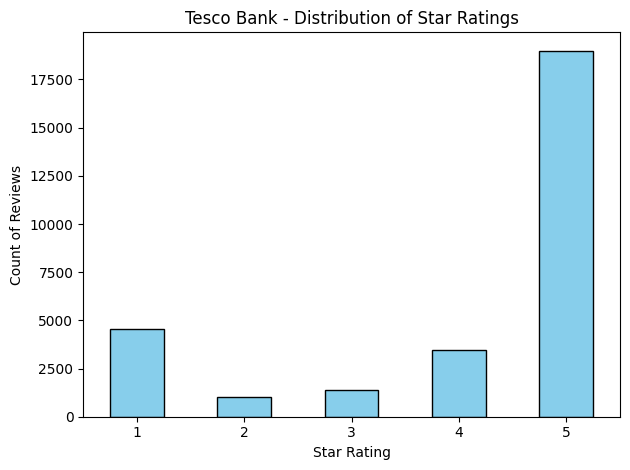

In [ ]:
import matplotlib.pyplot as plt

df['Star Rating'].value_counts().sort_index().plot(
    kind='bar', color='skyblue', edgecolor='black'
)
plt.title('Tesco Bank - Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count of Reviews')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
def rate_to_sentiment(star):
    if star <= 2:
        return 'Negative'
    elif star == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment Label'] = df['Star Rating'].apply(rate_to_sentiment)



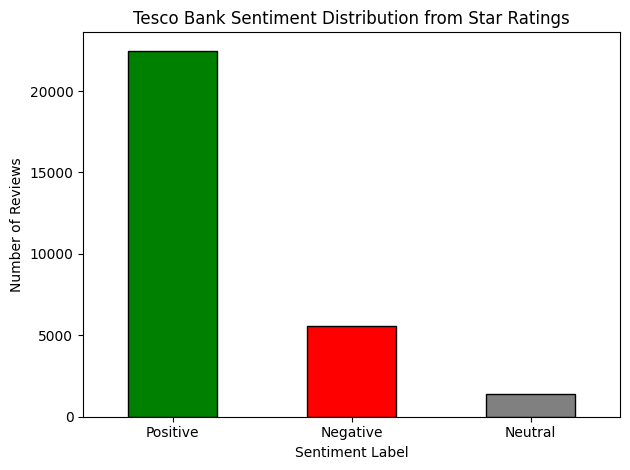

In [ ]:
import matplotlib.pyplot as plt

# Plot sentiment label distribution
df['Sentiment Label'].value_counts().plot(
    kind='bar',
    color=['green', 'red', 'grey'],  # red = Negative, gray = Neutral, green = Positive
    edgecolor='black'
)

plt.title('Tesco Bank Sentiment Distribution from Star Ratings')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [ ]:
!pip install --upgrade --force-reinstall numpy
!pip install --upgrade gensim

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  A

In [ ]:
from gensim.utils import simple_preprocess

In [ ]:
# Cleaning function
def clean_text(text):
    doc = nlp(str(text).lower())  # Ensure text is string
    return [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 2
    ]

# Apply cleaning
df['cleaned_text'] = df['Review Message'].apply(clean_text)

# Inspect cleaned data
print(df[['Review Message', 'cleaned_text']].head())


                                      Review Message  \
0  I called about a fraud scam.  The advisor had ...   
1  Easy application process, helpful and friendly...   
2  Application went through in minutes,great term...   
3  Extremely helpful and talked me through what I...   
4  When my problem was correctly identified I was...   

                                        cleaned_text  
0  [call, fraud, scam, advisor, knowledge, scam, ...  
1  [easy, application, process, helpful, friendly...  
2  [application, go, minute, great, term, month, ...  
3  [extremely, helpful, talk, need, sort, query, ...  
4  [problem, correctly, identify, able, contact, ...  


In [ ]:
!pip install gensim

In [ ]:
!pip install scipy==1.13.1


In [ ]:
pip install --force-reinstall gensim

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Att

In [ ]:
import gensim
print(gensim.__version__)

4.3.3


In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:
# Build bigram model
bigram = Phrases(df['cleaned_text'], min_count=5, threshold=10)
bigram_mod = Phraser(bigram)

# Apply bigram model
df['cleaned_text'] = df['cleaned_text'].apply(lambda text: bigram_mod[text])

In [ ]:
from gensim.corpora import Dictionary

# Create dictionary
id2word = Dictionary(df['cleaned_text'])

# Filter extremes (optional, for better topic quality)
id2word.filter_extremes(no_below=5, no_above=0.6)

# Create corpus (bag of words)
corpus = [id2word.doc2bow(text) for text in df['cleaned_text']]


In [ ]:
from gensim.models import LdaModel

# Train LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,         # Tune this value based on coherence score
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Print the topics
for idx, topic in lda_model.print_topics():
    print(f"Topic {idx}: {topic}\n")


Topic 0: 0.061*"tesco" + 0.033*"insurance" + 0.026*"year" + 0.026*"car" + 0.025*"pay" + 0.022*"policy" + 0.019*"company" + 0.016*"say" + 0.016*"car_insurance" + 0.015*"money"

Topic 1: 0.052*"tell" + 0.045*"phone" + 0.042*"account" + 0.032*"call" + 0.028*"card" + 0.027*"ask" + 0.025*"receive" + 0.025*"contact" + 0.023*"new" + 0.020*"charge"

Topic 2: 0.053*"claim" + 0.045*"tesco_bank" + 0.032*"bank" + 0.029*"customer" + 0.027*"try" + 0.023*"credit_card" + 0.020*"find" + 0.019*"payment" + 0.018*"know" + 0.017*"like"

Topic 3: 0.063*"service" + 0.057*"customer_service" + 0.038*"easy" + 0.035*"online" + 0.035*"helpful" + 0.034*"need" + 0.029*"speak" + 0.024*"process" + 0.024*"great" + 0.023*"staff"

Topic 4: 0.078*"time" + 0.058*"good" + 0.041*"use" + 0.034*"take" + 0.029*"give" + 0.028*"cover" + 0.027*"help" + 0.026*"experience" + 0.022*"renew" + 0.019*"avoid"



In [ ]:
from gensim.models import CoherenceModel

# Calculate coherence score
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=df['cleaned_text'],
    dictionary=id2word,
    coherence='c_v'
)

coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score}")


Coherence Score: 0.6401761651247828


In [ ]:
topic_labels = {
    0: "Insurance Claim Issues",
    1: "Account & Customer Support",
    2: "Credit Card Issues",
    3: "Customer Service Quality",
    4: "Insurance Coverage & Experience"
}

In [ ]:
for idx, topic in lda_model.print_topics():
    print(f"Topic {idx} - {topic_labels[idx]}: {topic}\n")


Topic 0 - Insurance Claim Issues: 0.061*"tesco" + 0.033*"insurance" + 0.026*"year" + 0.026*"car" + 0.025*"pay" + 0.022*"policy" + 0.019*"company" + 0.016*"say" + 0.016*"car_insurance" + 0.015*"money"

Topic 1 - Account & Customer Support: 0.052*"tell" + 0.045*"phone" + 0.042*"account" + 0.032*"call" + 0.028*"card" + 0.027*"ask" + 0.025*"receive" + 0.025*"contact" + 0.023*"new" + 0.020*"charge"

Topic 2 - Credit Card Issues: 0.053*"claim" + 0.045*"tesco_bank" + 0.032*"bank" + 0.029*"customer" + 0.027*"try" + 0.023*"credit_card" + 0.020*"find" + 0.019*"payment" + 0.018*"know" + 0.017*"like"

Topic 3 - Customer Service Quality: 0.063*"service" + 0.057*"customer_service" + 0.038*"easy" + 0.035*"online" + 0.035*"helpful" + 0.034*"need" + 0.029*"speak" + 0.024*"process" + 0.024*"great" + 0.023*"staff"

Topic 4 - Insurance Coverage & Experience: 0.078*"time" + 0.058*"good" + 0.041*"use" + 0.034*"take" + 0.029*"give" + 0.028*"cover" + 0.027*"help" + 0.026*"experience" + 0.022*"renew" + 0.019*"

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each review
df["Sentiment Score"] = df["Review Message"].apply(lambda text: sia.polarity_scores(text)["compound"])

# Assign topics to each review
df["Topic"] = [lda_model.get_document_topics(corpus[i], minimum_probability=0.3) for i in range(len(df))]

# Extract dominant topic per review and map it to topic name
df["Dominant Topic"] = df["Topic"].apply(lambda topics: topic_labels[max(topics, key=lambda x: x[1])[0]] if topics else None)

# Get average sentiment scores per topic
sentiment_by_topic = df.groupby("Dominant Topic")["Sentiment Score"].mean()

print("\n✅ Average Sentiment Score per Topic:")
print(sentiment_by_topic)


✅ Average Sentiment Score per Topic:
Dominant Topic
Account & Customer Support         0.116003
Credit Card Issues                 0.191608
Customer Service Quality           0.670325
Insurance Claim Issues             0.248509
Insurance Coverage & Experience    0.251480
Name: Sentiment Score, dtype: float64


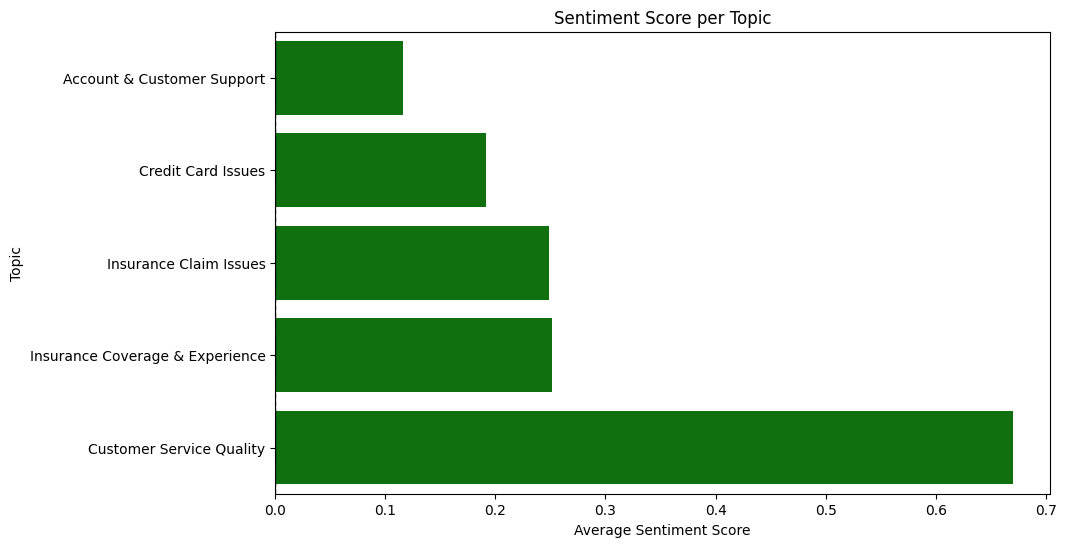

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort sentiment scores for better visualization
sentiment_by_topic = sentiment_by_topic.sort_values(ascending=True)

# Create a horizontal bar chart with all bars in green
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_by_topic.values, y=sentiment_by_topic.index, color="green")

# Labels and title
plt.xlabel("Average Sentiment Score")
plt.ylabel("Topic")
plt.title("Sentiment Score per Topic")
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)  # Vertical line at 0

# Remove legend (not needed when all bars are green)
plt.legend([],[], frameon=False)

# Show plot
plt.show()


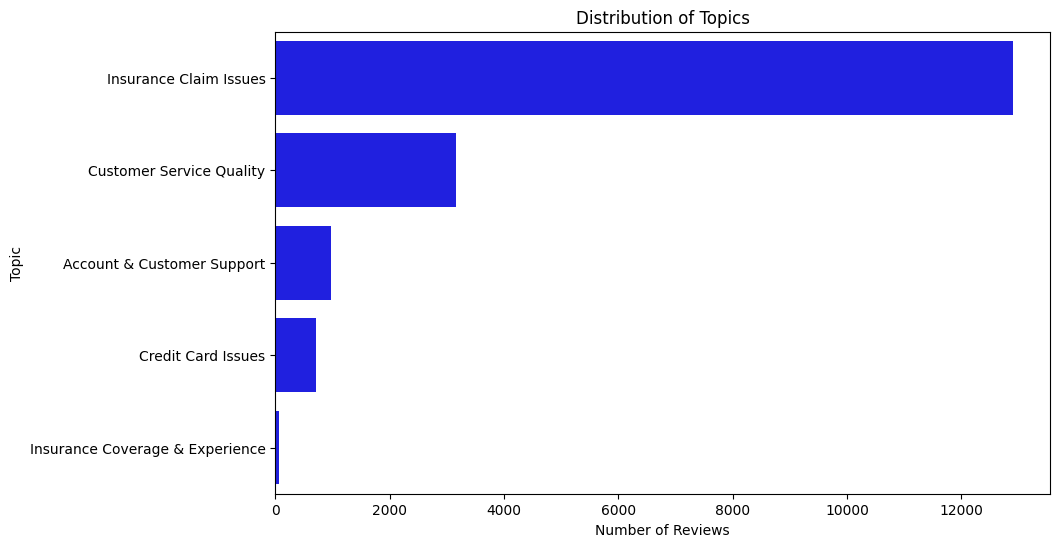

In [ ]:
# Count the number of reviews per topic
topic_distribution = df["Dominant Topic"].value_counts()

# Create a horizontal bar chart for topic distribution with blue bars
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_distribution.values, y=topic_distribution.index, color="blue")

# Labels and title
plt.xlabel("Number of Reviews")
plt.ylabel("Topic")
plt.title("Distribution of Topics")

# Show plot
plt.show()

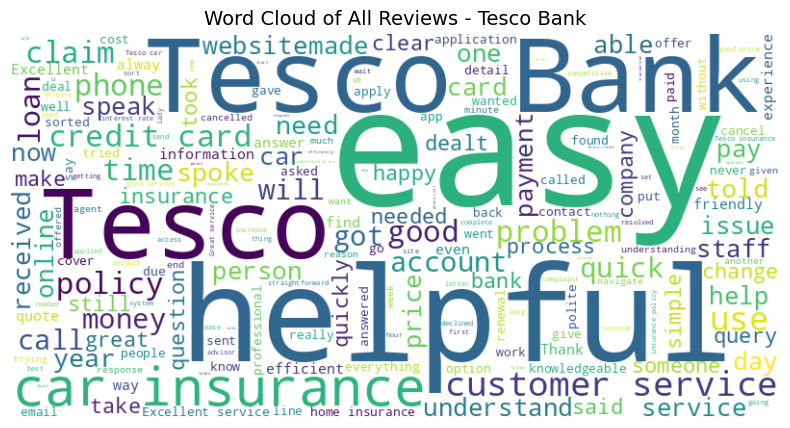

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Combine all reviews into a single string
all_reviews_text = " ".join(df["Review Message"].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(all_reviews_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes for better visualization
plt.title("Word Cloud of All Reviews - Tesco Bank", fontsize=14)
plt.show()

<Figure size 1200x600 with 0 Axes>

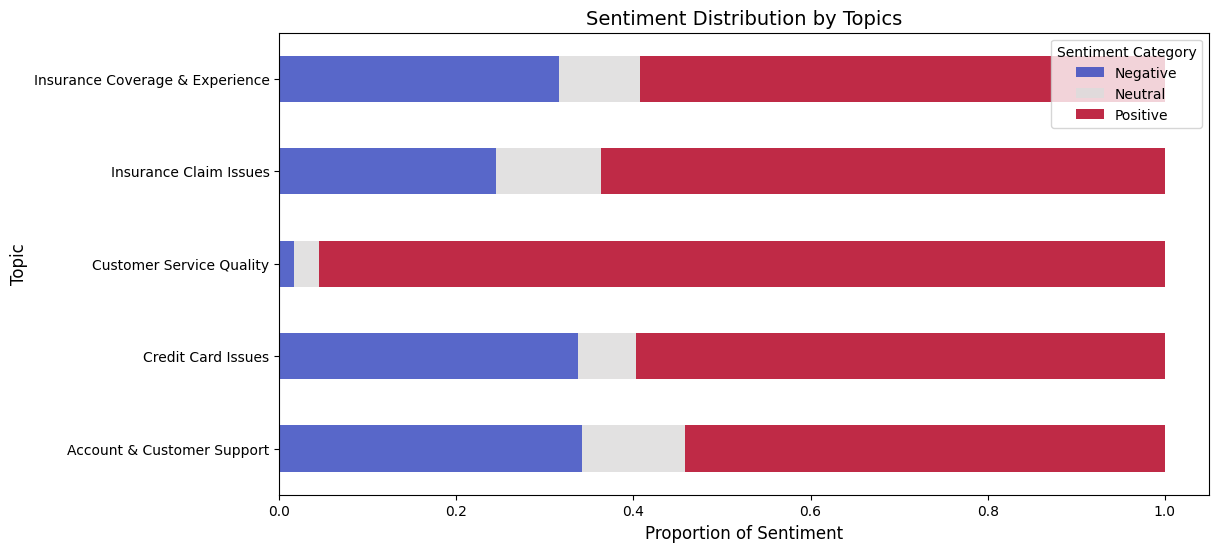

In [ ]:
# Define sentiment categories
df["Sentiment Category"] = df["Sentiment Score"].apply(lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral"))

# Calculate sentiment distribution per topic
sentiment_distribution = df.groupby("Dominant Topic")["Sentiment Category"].value_counts(normalize=True).unstack()

# Create a horizontal stacked bar chart
plt.figure(figsize=(12, 6))
sentiment_distribution.plot(kind="barh", stacked=True, colormap="coolwarm", alpha=0.85, figsize=(12, 6))

# Labels and title
plt.ylabel("Topic", fontsize=12)
plt.xlabel("Proportion of Sentiment", fontsize=12)
plt.title("Sentiment Distribution by Topics", fontsize=14)
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title="Sentiment Category")

# Show plot
plt.show()

<Figure size 1200x600 with 0 Axes>

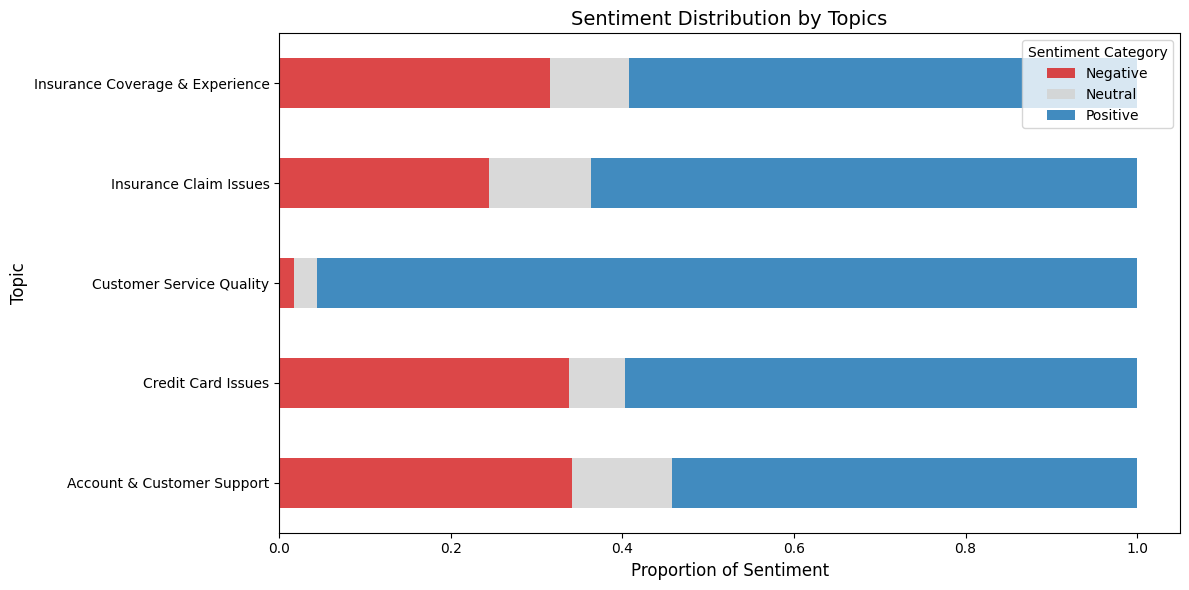

In [ ]:
# Define sentiment categories
df["Sentiment Category"] = df["Sentiment Score"].apply(lambda x: "Positive" if x > 0.05 else ("Negative" if x < -0.05 else "Neutral"))

# Calculate sentiment distribution per topic
sentiment_distribution = df.groupby("Dominant Topic")["Sentiment Category"].value_counts(normalize=True).unstack()

# Define custom color mapping: Negative = red, Neutral = grey, Positive = blue
custom_colors = {
    "Negative": "#d62728",  # red
    "Neutral": "#d3d3d3",   # light grey
    "Positive": "#1f77b4"   # blue
}

# Create a horizontal stacked bar chart
plt.figure(figsize=(12, 6))
sentiment_distribution.plot(
    kind="barh",
    stacked=True,
    color=[custom_colors[col] for col in sentiment_distribution.columns],  # apply custom colors
    alpha=0.85,
    figsize=(12, 6)
)

# Labels and title
plt.ylabel("Topic", fontsize=12)
plt.xlabel("Proportion of Sentiment", fontsize=12)
plt.title("Sentiment Distribution by Topics", fontsize=14)
plt.xticks(rotation=0)
plt.legend(title="Sentiment Category", loc="best")

# Show plot
plt.tight_layout()
plt.show()


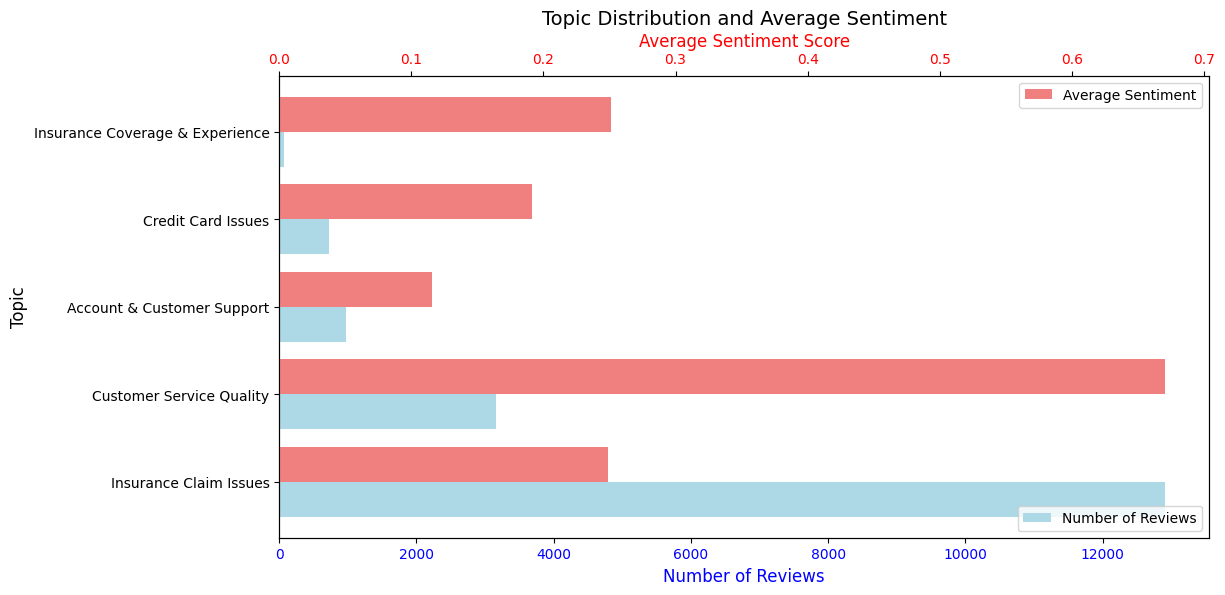

In [ ]:
import numpy as np
# Ensure both dictionaries have the same order
topics = list(topic_distribution.keys())
review_counts = np.array([topic_distribution[topic] for topic in topics])
sentiment_scores = np.array([sentiment_by_topic[topic] for topic in topics])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Define bar positions (y-coordinates)
y_pos = np.arange(len(topics))

# Plot topic distribution (Blue Bars - Reviews)
ax1.barh(y_pos - 0.2, review_counts, color="lightblue", height=0.4, label="Number of Reviews")
ax1.set_xlabel("Number of Reviews", color="blue", fontsize=12)
ax1.set_ylabel("Topic", fontsize=12)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(topics)
ax1.tick_params(axis="x", labelcolor="blue")

# Create second axis for sentiment scores
ax2 = ax1.twiny()

# Plot sentiment scores (Red Bars - Sentiment)
ax2.barh(y_pos + 0.2, sentiment_scores, color="lightcoral", height=0.4, label="Average Sentiment")
ax2.set_xlabel("Average Sentiment Score", color="red", fontsize=12)
ax2.tick_params(axis="x", labelcolor="red")

# Add title
plt.title("Topic Distribution and Average Sentiment", fontsize=14)

# Add legends at different positions
ax1.legend(loc="lower right", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)

# Show plot
plt.show()

In [ ]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.2 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Visualize the topics
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['Review Message'].apply(get_vader_sentiment)


In [ ]:
# Merge the manual sentiment annotations into the main dataset (on review text)
# Example: Merging on 'review_text' in df_reviews and 'review' in df_annotations
df_merged = df.merge(df_annotations[['Review message', 'Annotation']],
                             left_on='Review Message', right_on='Review message', how='left')


In [ ]:
df_merged = df_merged.drop(columns=['Review message'])

In [ ]:
df_merged.head()

,Author Name,Review Message,Review Date,Star Rating,Sentiment Label,cleaned_text,Sentiment Score,Topic,Dominant Topic,Sentiment Category,vader_sentiment,Annotation
0,Janet Wilson,I called about a fraud scam. The advisor had ...,2025-01-20,5,Positive,"[call, fraud, scam, advisor, knowledge, scam, ...",-0.8070,"[(1, 0.42304263)]",Account & Customer Support,Negative,negative,NaN
1,Janette,"Easy application process, helpful and friendly...",2025-01-22,5,Positive,"[easy, application_process, helpful, friendly,...",0.9517,"[(3, 0.4581004)]",Customer Service Quality,Positive,positive,NaN
2,pol,"Application went through in minutes,great term...",2025-01-22,5,Positive,"[application, go, minute, great, term, month, ...",0.8834,"[(0, 0.36645088), (2, 0.30059138)]",Insurance Claim Issues,Positive,positive,NaN
3,Mrs Ethel Griffiths,Extremely helpful and talked me through what I...,2025-01-19,5,Positive,"[extremely_helpful, talk, need, sort, query, t...",0.5849,[],None,Positive,positive,NaN
4,Jack,When my problem was correctly identified I was...,2025-01-20,5,Positive,"[problem, correctly, identify, able, contact, ...",-0.2732,"[(0, 0.3093616), (1, 0.4435031)]",Account & Customer Support,Negative,negative,NaN


In [ ]:
# Assign expected sentiment based on annotation or star rating
def define_expected_sentiment(row):
    if pd.notnull(row['Annotation']):
        return row['Annotation']  # Use manual label for 3-star
    elif row['Star Rating'] in [1, 2]:
        return 'negative'
    elif row['Star Rating'] in [4, 5]:
        return 'positive'
    else:
        return 'neutral'  # fallback for unexpected cases

df_merged['expected_sentiment'] = df_merged.apply(define_expected_sentiment, axis=1)


In [ ]:
df_merged.head()

,Author Name,Review Message,Review Date,Star Rating,Sentiment Label,cleaned_text,Sentiment Score,Topic,Dominant Topic,Sentiment Category,vader_sentiment,Annotation,expected_sentiment
0,Janet Wilson,I called about a fraud scam. The advisor had ...,2025-01-20,5,Positive,"[call, fraud, scam, advisor, knowledge, scam, ...",-0.8070,"[(1, 0.42304263)]",Account & Customer Support,Negative,negative,NaN,positive
1,Janette,"Easy application process, helpful and friendly...",2025-01-22,5,Positive,"[easy, application_process, helpful, friendly,...",0.9517,"[(3, 0.4581004)]",Customer Service Quality,Positive,positive,NaN,positive
2,pol,"Application went through in minutes,great term...",2025-01-22,5,Positive,"[application, go, minute, great, term, month, ...",0.8834,"[(0, 0.36645088), (2, 0.30059138)]",Insurance Claim Issues,Positive,positive,NaN,positive
3,Mrs Ethel Griffiths,Extremely helpful and talked me through what I...,2025-01-19,5,Positive,"[extremely_helpful, talk, need, sort, query, t...",0.5849,[],None,Positive,positive,NaN,positive
4,Jack,When my problem was correctly identified I was...,2025-01-20,5,Positive,"[problem, correctly, identify, able, contact, ...",-0.2732,"[(0, 0.3093616), (1, 0.4435031)]",Account & Customer Support,Negative,negative,NaN,positive


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_true = df_merged['expected_sentiment']
y_pred = df_merged['vader_sentiment']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.76
Precision: 0.80
Recall: 0.76
F1 Score: 0.78

Classification Report:


ValueError: Number of classes, 8, does not match size of target_names, 3. Try specifying the labels parameter

In [ ]:
print("y_true labels:", y_true.unique())
print("y_pred labels:", y_pred.unique())

y_true labels: ['positive' 'negative' 'neutral' 'Negative' 'Positive' 'Neutral'
 ' Negative' 'Neutal']
y_pred labels: ['negative' 'positive' 'neutral']


In [ ]:
# Step 1: Define a manual correction map for typos and inconsistencies
label_corrections = {
    'positive': 'positive',
    'Positive': 'positive',
    ' negative': 'negative',
    'Negative': 'negative',
    'negative': 'negative',
    ' neutral': 'neutral',
    'Neutral': 'neutral',
    'neutral': 'neutral',
    'Neutal': 'neutral'  # typo correction
}

# Step 2: Apply correction to y_true (expected_sentiment column)
df_merged['expected_sentiment'] = df_merged['expected_sentiment'].map(label_corrections)

# Step 3: Filter to keep only valid, non-null rows
valid_sentiments = ['negative', 'neutral', 'positive']
df_clean = df_merged[
    df_merged['expected_sentiment'].isin(valid_sentiments) &
    df_merged['vader_sentiment'].isin(valid_sentiments)
]

# Redefine y_true and y_pred
y_true = df_clean['expected_sentiment']
y_pred = df_clean['vader_sentiment']


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive'], zero_division=0))


Accuracy: 0.78
Precision: 0.85
Recall: 0.78
F1 Score: 0.81

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.55      0.62      6654
     neutral       0.01      0.15      0.02       226
    positive       0.89      0.86      0.87     22592

    accuracy                           0.78     29472
   macro avg       0.54      0.52      0.51     29472
weighted avg       0.85      0.78      0.81     29472



In [ ]:
!pip install transformers torch emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 45.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import re

# Define a lightweight cleaning function
def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip()             # Remove extra whitespace
    text = text.replace('\n', ' ').replace('\r', ' ')    # Flatten line breaks
    return text

# Apply to your dataset
df_merged['Review Message'] = df_clean['Review Message'].apply(clean_text)


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Mapping output class to sentiment
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}

def batch_bert_sentiment(df_merged, batch_size=32):
    texts = list(df_merged['Review Message'].astype(str))  # Ensure strings

    # Tokenize all at once
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

    # Move inputs to GPU
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Batch input
    dataset = TensorDataset(input_ids, attention_mask)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Predict in batches
    predictions = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            ids, masks = batch
            outputs = model(input_ids=ids, attention_mask=masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)

    # Convert to sentiment labels
    return [id2label[pred] for pred in predictions]


In [ ]:
# Run the sentiment prediction — fast and efficient!
df_merged['bert_sentiment'] = batch_bert_sentiment(df_merged)

In [ ]:
print("y_true classes:", sorted(y_true.unique()))
print("y_pred classes:", sorted(y_pred.unique()))

y_true classes: ['negative', 'neutral', 'positive']
y_pred classes: ['negative', 'neutral', 'positive']


In [ ]:
# Clean and filter invalid entries
valid_labels = ['negative', 'neutral', 'positive']

# Drop rows with 'nan' (string) or actual NaN in y_true or y_pred
df_cleaned = df_merged[
    df_merged['expected_sentiment'].astype(str).str.strip().str.lower().isin(valid_labels) &
    df_merged['bert_sentiment'].astype(str).str.strip().str.lower().isin(valid_labels)
].copy()

# Standardize the labels
df_cleaned['expected_sentiment'] = df_cleaned['expected_sentiment'].str.strip().str.lower()
df_cleaned['bert_sentiment'] = df_cleaned['bert_sentiment'].str.strip().str.lower()

# Redefine y_true and y_pred
y_true = df_cleaned['expected_sentiment']
y_pred = df_cleaned['bert_sentiment']


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=['negative', 'neutral', 'positive'],
    zero_division=0
))


Accuracy: 0.8220344733984799

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.84      0.85      6654
     neutral       0.02      0.45      0.05       226
    positive       0.99      0.82      0.90     22592

    accuracy                           0.82     29472
   macro avg       0.62      0.70      0.60     29472
weighted avg       0.95      0.82      0.88     29472



In [ ]:
import torch.nn.functional as F

def batch_bert_sentiment_scores(df_merged, batch_size=32):
    texts = list(df_merged['Review Message'].astype(str))  # Ensure strings

    # Tokenize all at once
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

    # Move inputs to GPU
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Batch input
    dataset = TensorDataset(input_ids, attention_mask)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Predict in batches
    predictions = []
    scores = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            ids, masks = batch
            outputs = model(input_ids=ids, attention_mask=masks)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)
            predictions.extend(preds)

            # You can pick the confidence of the predicted label
            predicted_scores = probs[np.arange(len(probs)), preds]
            scores.extend(predicted_scores)

    # Convert to sentiment labels
    labels = [id2label[pred] for pred in predictions]

    return labels, scores


In [ ]:
# Run prediction
labels, scores = batch_bert_sentiment_scores(df_merged)

# Add to your dataframe
df_merged['bert_sentiment'] = labels
df_merged['bert_sentiment_score'] = scores


In [ ]:
df_merged.head(20)

,Author Name,Review Message,Review Date,Star Rating,Sentiment Label,cleaned_text,Sentiment Score,Topic,Dominant Topic,Sentiment Category,vader_sentiment,Annotation,expected_sentiment,bert_sentiment,bert_sentiment_score
0,Janet Wilson,i called about a fraud scam. the advisor had k...,2025-01-20,5,Positive,"[call, fraud, scam, advisor, knowledge, scam, ...",-0.8070,"[(1, 0.42304263)]",Account & Customer Support,Negative,negative,NaN,positive,negative,0.628396
1,Janette,"easy application process, helpful and friendly...",2025-01-22,5,Positive,"[easy, application_process, helpful, friendly,...",0.9517,"[(3, 0.4581004)]",Customer Service Quality,Positive,positive,NaN,positive,positive,0.956515
2,pol,"application went through in minutes,great term...",2025-01-22,5,Positive,"[application, go, minute, great, term, month, ...",0.8834,"[(0, 0.36645088), (2, 0.30059138)]",Insurance Claim Issues,Positive,positive,NaN,positive,positive,0.953952
3,Mrs Ethel Griffiths,extremely helpful and talked me through what i...,2025-01-19,5,Positive,"[extremely_helpful, talk, need, sort, query, t...",0.5849,[],None,Positive,positive,NaN,positive,positive,0.898076
4,Jack,when my problem was correctly identified i was...,2025-01-20,5,Positive,"[problem, correctly, identify, able, contact, ...",-0.2732,"[(0, 0.3093616), (1, 0.4435031)]",Account & Customer Support,Negative,negative,NaN,positive,positive,0.739767
5,L VIJAYAKUMAR,i like very much for tesco bank because the st...,2025-01-22,5,Positive,"[like, tesco_bank, staff, nice, talk, respect,...",0.9468,"[(2, 0.3909676)]",Credit Card Issues,Positive,positive,NaN,positive,positive,0.987960
6,Dave Howitt,i wanted to increase the owed amount on an exi...,2025-01-16,5,Positive,"[want, increase, owe, exist, loan, advisor, ex...",0.5980,"[(0, 0.48752165)]",Insurance Claim Issues,Positive,positive,NaN,positive,positive,0.923687
7,Mr Mark Mews,tesco card staff are very polite and very info...,2025-01-20,5,Positive,"[tesco, card, staff, polite, informative, extr...",0.7083,"[(0, 0.39414224)]",Insurance Claim Issues,Positive,positive,NaN,positive,positive,0.983443
8,PATRICIA BETTANEY,the wonderful girl who assisted me was profess...,2025-01-22,5,Positive,"[wonderful, girl, assist, professional, kind, ...",0.9312,"[(3, 0.39534402)]",Customer Service Quality,Positive,positive,NaN,positive,positive,0.962936
9,Mike Henry,i had unexpected interest payments shown on my...,2025-01-17,5,Positive,"[unexpected, interest, payment, show, credit_c...",0.8402,[],None,Positive,positive,NaN,positive,neutral,0.489746


In [ ]:
df_negative = df[df['Star Rating'].isin([1, 2, 3])]

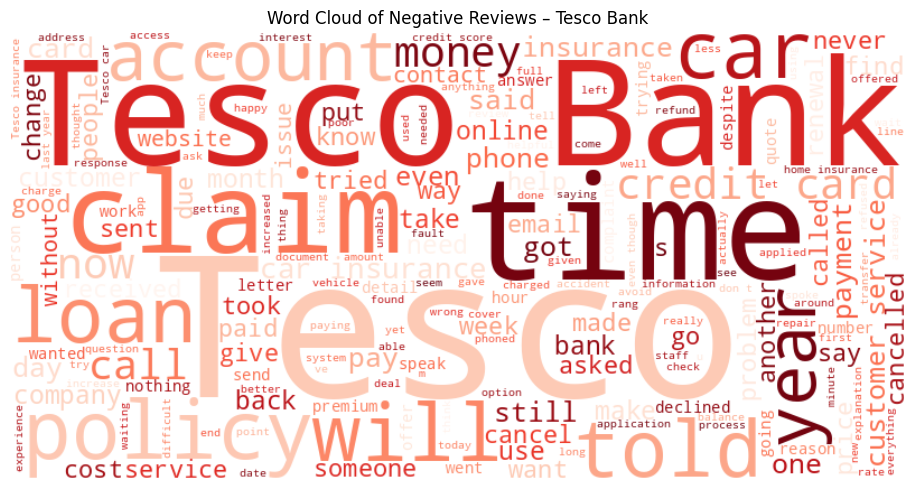

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all review messages into one string
text_negative = " ".join(review for review in df_negative['Review Message'].astype(str))

# Define additional stopwords if needed
custom_stopwords = set(STOPWORDS)

# Create the word cloud
wordcloud_negative = WordCloud(width=800, height=400,
                               background_color='white',
                               stopwords=custom_stopwords,
                               colormap='Reds').generate(text_negative)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Reviews – Tesco Bank")
plt.tight_layout()
plt.show()


In [ ]:
df_negative.head()

,Author Name,Review Message,Review Date,Star Rating,Sentiment Label,cleaned_text,Sentiment Score,Topic,Dominant Topic,Sentiment Category,vader_sentiment
14,Siet,Eligibility check stated 90% acceptance which ...,2025-01-22,1,Negative,"[eligibility, check, state, acceptance, reason...",0.9565,"[(2, 0.51947176)]",Credit Card Issues,Positive,positive
15,Val,I had a bond which mature 18th January but I h...,2025-01-20,1,Negative,"[bond_mature, january, original, capital, retu...",0.9526,"[(0, 0.54200816)]",Insurance Claim Issues,Positive,positive
17,Samantha Plews,I received a letter to say my credit card bala...,2025-01-22,1,Negative,"[receive_letter, credit_card, balance, increas...",0.8765,"[(0, 0.3781592)]",Insurance Claim Issues,Positive,positive
22,Simon Marchant,Credit score with Clear Score currently at 912...,2025-01-22,2,Negative,"[credit_score, clear, score, currently, score_...",0.7557,"[(0, 0.50928205)]",Insurance Claim Issues,Positive,positive
27,Andy Gamlin,Absolutely appalling! I pay my bill on the dat...,2025-01-20,1,Negative,"[absolutely_appalling, pay_bill, date, show, i...",-0.8955,"[(1, 0.45119825)]",Account & Customer Support,Negative,negative


In [ ]:
# Create corpus for df_negative using the existing id2word dictionary
corpus_negative = [id2word.doc2bow(text) for text in df_negative['cleaned_text']]


In [ ]:
from gensim.models import LdaModel

lda_model_negative = LdaModel(corpus=corpus_negative,
                              id2word=id2word,
                              num_topics=3,  # or however many you want
                              random_state=42,
                              passes=10,
                              per_word_topics=True)

# Display topics
for idx, topic in lda_model_negative.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.022*"tesco" + 0.021*"account" + 0.018*"bank" + 0.015*"card" + 0.015*"credit_card" + 0.014*"tesco_bank" + 0.013*"money" + 0.013*"loan" + 0.012*"pay" + 0.010*"payment"
Topic 1: 0.020*"phone" + 0.015*"tell" + 0.015*"time" + 0.013*"tesco" + 0.013*"customer_service" + 0.012*"call" + 0.011*"speak" + 0.009*"try" + 0.009*"contact" + 0.009*"car"
Topic 2: 0.033*"tesco" + 0.032*"insurance" + 0.023*"year" + 0.023*"policy" + 0.023*"claim" + 0.018*"car" + 0.016*"pay" + 0.013*"car_insurance" + 0.013*"company" + 0.012*"cancel"


In [ ]:

# Compute Coherence Score
coherence_model_negative = CoherenceModel(
    model=lda_model_negative,
    texts=df_negative['cleaned_text'],  # this should be tokenized text (list of words)
    dictionary=id2word,
    coherence='c_v'  # 'c_v' is a popular choice, but others are available
)

coherence_score = coherence_model_negative.get_coherence()
print(f"\nCoherence Score: {coherence_score:.4f}")



Coherence Score: 0.6003


In [ ]:
topic_labels = {
    0: "Credit card Issues",
    1: "Customer Service Complaints",
    2: "Insurance Claims & Policy Issues"
}


In [ ]:
print(df_negative.columns)


Index(['Author Name', 'Review Message', 'Review Date', 'Star Rating',
       'Sentiment Label', 'cleaned_text', 'Sentiment Score', 'Topic',
       'Dominant Topic', 'Sentiment Category', 'vader_sentiment'],
      dtype='object')


In [ ]:
topic_labels = {
    0: "Credit card Issues",
    1: "Customer Service Complaints",
    2: "Insurance Claims & Policy Issues"
}

# 2. Function to get dominant topic index
def get_dominant_topic(ldamodel, corpus):
    dominant_topics = []
    for bow in corpus:
        topic_probs = ldamodel.get_document_topics(bow)
        if topic_probs:
            dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
            dominant_topics.append(dominant_topic)
        else:
            dominant_topics.append(None)
    return dominant_topics

# 3. Apply to negative reviews
df_negative['Theme'] = get_dominant_topic(lda_model_negative, corpus_negative)

# 4. Create final DataFrame with the columns you want
df_negative_selected = df_negative[['cleaned_text', 'Sentiment Score', 'Theme']].copy()

# 5. Map the topic labels as 'Theme Label'
df_negative_selected['Theme Label'] = df_negative_selected['Theme'].map(topic_labels)

# 6. Done! Preview your data
print(df_negative_selected.head())


                                         cleaned_text  Sentiment Score  Theme  \
14  [eligibility, check, state, acceptance, reason...           0.9565      0   
15  [bond_mature, january, original, capital, retu...           0.9526      0   
17  [receive_letter, credit_card, balance, increas...           0.8765      0   
22  [credit_score, clear, score, currently, score_...           0.7557      0   
27  [absolutely_appalling, pay_bill, date, show, i...          -0.8955      0   

           Theme Label  
14  Credit card Issues  
15  Credit card Issues  
17  Credit card Issues  
22  Credit card Issues  
27  Credit card Issues  


<ipython-input-73-75a27b1fbac9>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negative['Theme'] = get_dominant_topic(lda_model_negative, corpus_negative)


In [ ]:
df_negative.loc[:, 'Theme Label'] = df_negative['Theme'].map(topic_labels)

<ipython-input-74-83e1b11dd702>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negative.loc[:, 'Theme Label'] = df_negative['Theme'].map(topic_labels)


In [ ]:
# Step 3: Select the key columns
df_negative_selected = df_negative[['cleaned_text', 'Sentiment Score', 'Theme Label']].copy()

In [ ]:
df_negative_selected.head()

,cleaned_text,Sentiment Score,Theme Label
14,"[eligibility, check, state, acceptance, reason...",0.9565,Credit card Issues
15,"[bond_mature, january, original, capital, retu...",0.9526,Credit card Issues
17,"[receive_letter, credit_card, balance, increas...",0.8765,Credit card Issues
22,"[credit_score, clear, score, currently, score_...",0.7557,Credit card Issues
27,"[absolutely_appalling, pay_bill, date, show, i...",-0.8955,Credit card Issues


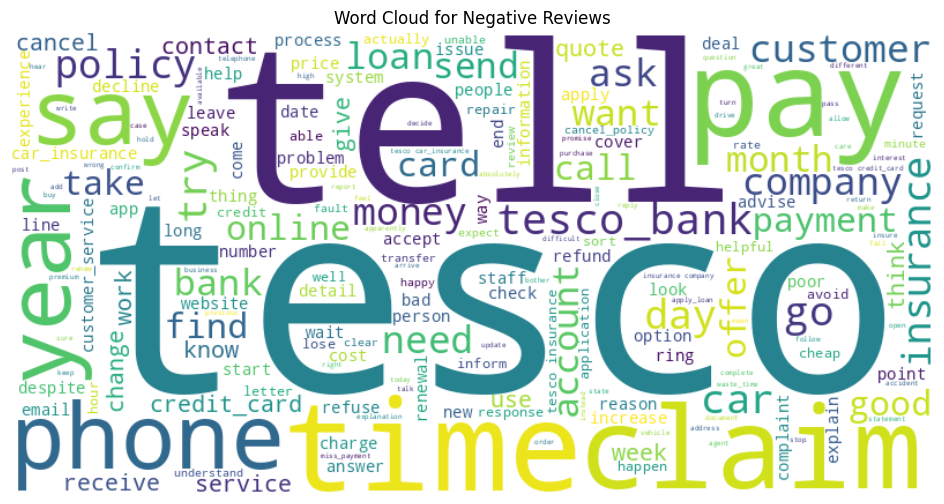

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all words in cleaned_text into a single string
text = ' '.join([' '.join(words) for words in df_negative_selected['cleaned_text'] if isinstance(words, list)])

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews")
plt.show()


                        Theme Label  Count
0                Credit card Issues   2663
1       Customer Service Complaints   2214
2  Insurance Claims & Policy Issues   2112


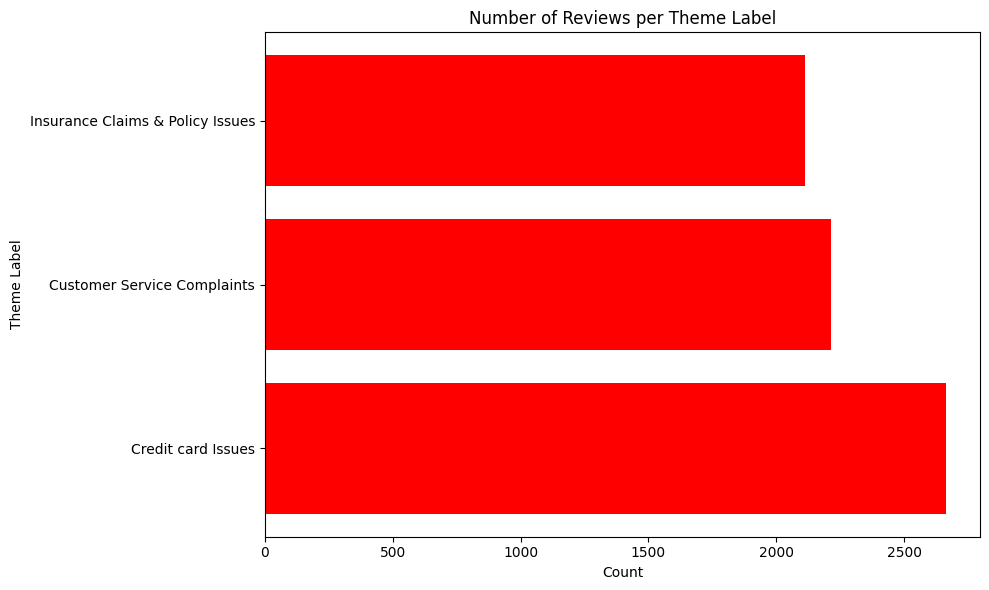

In [ ]:
# Count the number of reviews per Theme Label
theme_counts = df_negative_selected['Theme Label'].value_counts().reset_index()
theme_counts.columns = ['Theme Label', 'Count']
print(theme_counts)

# Horizontal bar chart with red bars
plt.figure(figsize=(10, 6))
plt.barh(theme_counts['Theme Label'], theme_counts['Count'], color='red')
plt.title('Number of Reviews per Theme Label')
plt.xlabel('Count')
plt.ylabel('Theme Label')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load CSV file
df_store = pd.read_csv('/content/drive/MyDrive/MSc Dissertation/Tescostore (2).csv')

In [ ]:
df_store.head()

,Author Name,Review Message,Review Date,Star Rating
0,Monika Matuszewska,Tesco Newbury home delivery.This is disgusting...,"Date of experience: January 20, 2025",Rated 1 out of 5 stars
1,Louise,I have been shopping in Tesco for years. I hav...,"Date of experience: January 20, 2025",Rated 1 out of 5 stars
2,Roger Nicholls,Purchased a Tesco Hearty Food Co Spaghetti Bol...,"Date of experience: January 21, 2025",Rated 1 out of 5 stars
3,Mark Eley,Last shop ever at Tesco just do not trust the ...,"Date of experience: January 22, 2025",Rated 1 out of 5 stars
4,Carole Sefton,The app on my phone has stopped working althou...,"Date of experience: January 20, 2025",Rated 1 out of 5 stars


In [ ]:
df_store['Review Date'] = df_store['Review Date'].str.replace('Date of experience: ', '').str.strip()
df_store['Star Rating'] = df_store['Star Rating'].str.extract(r'(\d+)').astype('Int64')

In [ ]:
df_store['Review Date'] = pd.to_datetime(df_store['Review Date'], errors='coerce')


In [ ]:
df_store = df_store.dropna(subset=['Review Message'])

In [ ]:
# Remove duplicates
df_store = df_store.drop_duplicates()

In [ ]:
df_annotations['Date'] = pd.to_datetime(df_annotations['Date'], errors='coerce')

In [ ]:
df_store['Author Name'] = df_store['Author Name'].fillna('Anonymous')

In [ ]:
c = df_store[df_store['Review Date'].dt.year.between(2020, 2025)]

In [ ]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15186 entries, 0 to 15508
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Author Name     15186 non-null  object        
 1   Review Message  15186 non-null  object        
 2   Review Date     15185 non-null  datetime64[ns]
 3   Star Rating     15185 non-null  Int64         
dtypes: Int64(1), datetime64[ns](1), object(2)
memory usage: 608.0+ KB


In [ ]:
# Show rows where Review Date is missing
print(df_store[df_store['Review Date'].isna()])

# Show rows where Star Rating is missing
print(df_store[df_store['Star Rating'].isna()])


      Author Name                                     Review Message  \
12237        Yeet  Lorem ipsum dolor sit amet, consectetur adipis...   

      Review Date  Star Rating  
12237         NaT         <NA>  
      Author Name                                     Review Message  \
12237        Yeet  Lorem ipsum dolor sit amet, consectetur adipis...   

      Review Date  Star Rating  
12237         NaT         <NA>  


In [ ]:
# Drop row with index 12237
df_store = df_store.drop(index=12237).reset_index(drop=True)


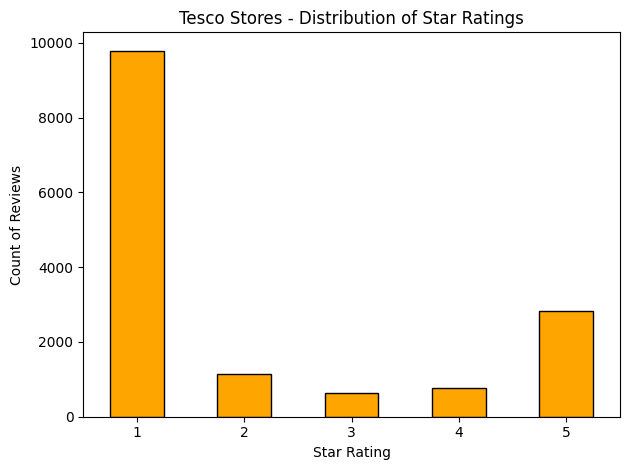

In [ ]:
import matplotlib.pyplot as plt

df_store['Star Rating'].value_counts().sort_index().plot(
    kind='bar', color='orange', edgecolor='black'
)
plt.title('Tesco Stores - Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count of Reviews')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
def rate_to_sentiment(star):
    if star <= 2:
        return 'Negative'
    elif star == 3:
        return 'Neutral'
    else:
        return 'Positive'

df_store['Sentiment Label'] = df_store['Star Rating'].apply(rate_to_sentiment)



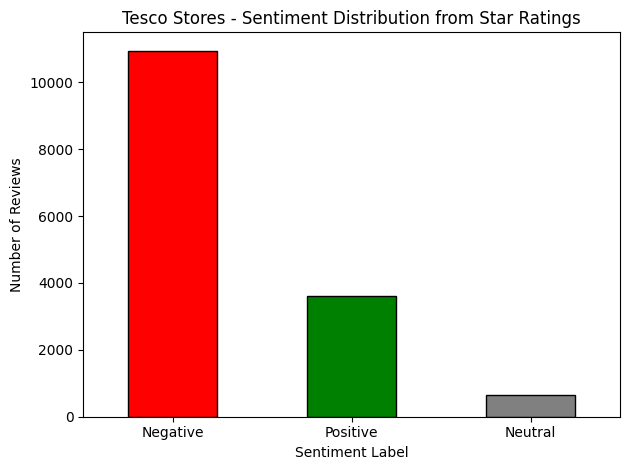

In [ ]:
import matplotlib.pyplot as plt

# Plot sentiment label distribution
df_store['Sentiment Label'].value_counts().plot(
    kind='bar',
    color=['red', 'green', 'gray'],  # red = Negative, gray = Neutral, green = Positive
    edgecolor='black'
)

plt.title('Tesco Stores - Sentiment Distribution from Star Ratings')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Cleaning function
def clean_text(text):
    doc = nlp(str(text).lower())  # Ensure text is string
    return [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 2
    ]

# Apply cleaning
df_store['cleaned_text'] = df_store['Review Message'].apply(clean_text)

# Inspect cleaned data
print(df_store[['Review Message', 'cleaned_text']].head())

                                      Review Message  \
0  Tesco Newbury home delivery.This is disgusting...   
1  I have been shopping in Tesco for years. I hav...   
2  Purchased a Tesco Hearty Food Co Spaghetti Bol...   
3  Last shop ever at Tesco just do not trust the ...   
4  The app on my phone has stopped working althou...   

                                        cleaned_text  
0  [tesco, newbury, home, disgusting, receive, me...  
1  [shop, tesco, year, shopping, deliver, big, fa...  
2  [purchase, tesco, hearty, food, spaghetti, bol...  
3  [shop, tesco, trust, quality, food, chicken, b...  
4  [app, phone, stop, work, change, try, uninstal...  


In [ ]:
# Tokenize and lowercase, remove punctuation
tokenized_texts = df_store['Review Message'].dropna().apply(
    lambda x: simple_preprocess(str(x), deacc=True)
).tolist()


In [ ]:
# Build bigram model
bigram = Phrases(df_store['cleaned_text'], min_count=5, threshold=10)
bigram_mod = Phraser(bigram)

# Apply bigram model
df_store['cleaned_text'] = df_store['cleaned_text'].apply(lambda text: bigram_mod[text])

In [ ]:
import nltk

# Download essential tokenizers
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Apply stopword filtering
tokenized_texts = df_store['Review Message'].dropna().apply(
    lambda x: [word for word in simple_preprocess(str(x), deacc=True) if word not in stop_words]
).tolist()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

# Build the bigram and trigram models
bigram = Phrases(tokenized_texts, min_count=5, threshold=100)
trigram = Phrases(bigram[tokenized_texts], threshold=100)

# Faster transformation
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Apply bigrams and trigrams
texts_bigrams = [bigram_mod[doc] for doc in tokenized_texts]
texts_trigrams = [trigram_mod[bigram_mod[doc]] for doc in tokenized_texts]


In [ ]:
# Lemmatize while keeping only nouns, adjectives, verbs, adverbs
def lemmatize_texts(texts):
    lemmatized_texts = []
    for doc in texts:
        joined = ' '.join(doc)  # Convert list to string
        spacy_doc = nlp(joined)
        lemmatized_texts.append([token.lemma_ for token in spacy_doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])
    return lemmatized_texts

texts_lemmatized = lemmatize_texts(texts_trigrams)


In [ ]:
from gensim.corpora import Dictionary

# Create Dictionary and Corpus for Tesco Stores
id2word_stores = Dictionary(texts_lemmatized)
corpus_stores = [id2word_stores.doc2bow(text) for text in texts_lemmatized]


In [ ]:
from gensim.models import LdaModel

lda_model_stores = LdaModel(
    corpus=corpus_stores,
    id2word=id2word_stores,
    num_topics=6,               # You can still tune this
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)


In [ ]:
topics = lda_model_stores.print_topics(num_words=10)
for idx, topic in topics:
    print(f"Theme {idx}: {topic}")


Theme 0: 0.081*"delivery" + 0.071*"order" + 0.040*"day" + 0.036*"time" + 0.035*"service" + 0.034*"online" + 0.033*"deliver" + 0.032*"item" + 0.025*"driver" + 0.021*"grocery"
Theme 1: 0.065*"good" + 0.044*"buy" + 0.038*"product" + 0.026*"food" + 0.018*"cheap" + 0.017*"stock" + 0.017*"date" + 0.017*"quality" + 0.017*"supermarket" + 0.015*"find"
Theme 2: 0.037*"tesco" + 0.036*"shop" + 0.034*"use" + 0.029*"go" + 0.024*"get" + 0.024*"price" + 0.017*"time" + 0.014*"never" + 0.013*"year" + 0.012*"offer"
Theme 3: 0.035*"say" + 0.030*"customer" + 0.027*"tell" + 0.024*"take" + 0.022*"get" + 0.018*"ask" + 0.017*"come" + 0.017*"call" + 0.016*"phone" + 0.016*"back"
Theme 4: 0.053*"store" + 0.041*"always" + 0.040*"service" + 0.029*"staff" + 0.023*"customer" + 0.023*"great" + 0.016*"good" + 0.014*"shopping" + 0.013*"easy" + 0.013*"helpful"
Theme 5: 0.027*"else" + 0.026*"option" + 0.024*"generally" + 0.021*"rate" + 0.021*"contract" + 0.016*"bread" + 0.014*"road" + 0.012*"select" + 0.012*"slow" + 0.011

In [ ]:
from gensim.models import CoherenceModel

coherence_model_stores = CoherenceModel(
    model=lda_model_stores,
    texts=texts_lemmatized,   # your final tokenized store reviews
    dictionary=id2word,       # if you've renamed it, use id2word_stores
    coherence='c_v'
)
coherence_score_stores = coherence_model_stores.get_coherence()
print(f"\nTesco Stores Coherence Score: {coherence_score_stores:.4f}")



Tesco Stores Coherence Score: 0.5002


In [ ]:
store_themes = {
0: "Delivery Problem",
1: "Product Quality and Value",
2: "Shopping at Tesco/Billing",
3: "Customer Service Interactions",
4: "In-Store Experience",
5: "Alternative Options and Comparisons"
}

In [ ]:
for idx, topic in lda_model_stores.print_topics():
    print(f"Theme {idx} - {store_themes[idx]}: {topic}\n")


Theme 0 - Delivery Problem: 0.081*"delivery" + 0.071*"order" + 0.040*"day" + 0.036*"time" + 0.035*"service" + 0.034*"online" + 0.033*"deliver" + 0.032*"item" + 0.025*"driver" + 0.021*"grocery"

Theme 1 - Product Quality and Value: 0.065*"good" + 0.044*"buy" + 0.038*"product" + 0.026*"food" + 0.018*"cheap" + 0.017*"stock" + 0.017*"date" + 0.017*"quality" + 0.017*"supermarket" + 0.015*"find"

Theme 2 - Shopping at Tesco/Billing: 0.037*"tesco" + 0.036*"shop" + 0.034*"use" + 0.029*"go" + 0.024*"get" + 0.024*"price" + 0.017*"time" + 0.014*"never" + 0.013*"year" + 0.012*"offer"

Theme 3 - Customer Service Interactions: 0.035*"say" + 0.030*"customer" + 0.027*"tell" + 0.024*"take" + 0.022*"get" + 0.018*"ask" + 0.017*"come" + 0.017*"call" + 0.016*"phone" + 0.016*"back"

Theme 4 - In-Store Experience: 0.053*"store" + 0.041*"always" + 0.040*"service" + 0.029*"staff" + 0.023*"customer" + 0.023*"great" + 0.016*"good" + 0.014*"shopping" + 0.013*"easy" + 0.013*"helpful"

Theme 5 - Alternative Options

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Step 1: Apply sentiment analysis to each review
df_store["Sentiment Score"] = df_store["Review Message"].apply(
    lambda text: sia.polarity_scores(text)["compound"]
)

# Step 2: Assign topic distribution from the LDA model
df_store["Topic"] = [
    lda_model_stores.get_document_topics(corpus_stores[i], minimum_probability=0.3)
    for i in range(len(df_store))
]

# Step 3: Extract dominant topic and map to store theme label
df_store["Dominant Topic"] = df_store["Topic"].apply(
    lambda topics: store_themes[max(topics, key=lambda x: x[1])[0]] if topics else None
)

# Step 4: Calculate average sentiment per topic
sentiment_by_topic_store = df_store.groupby("Dominant Topic")["Sentiment Score"].mean()

# Display result
print("\n✅ Average Sentiment Score per Tesco Store Topic:")
print(sentiment_by_topic_store)



✅ Average Sentiment Score per Tesco Store Topic:
Dominant Topic
Alternative Options and Comparisons   -0.090200
Customer Service Interactions         -0.337584
Delivery Problem                      -0.236154
In-Store Experience                    0.305152
Product Quality and Value             -0.062574
Shopping at Tesco/Billing             -0.095706
Name: Sentiment Score, dtype: float64


<ipython-input-141-bb9a3b29e1c6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


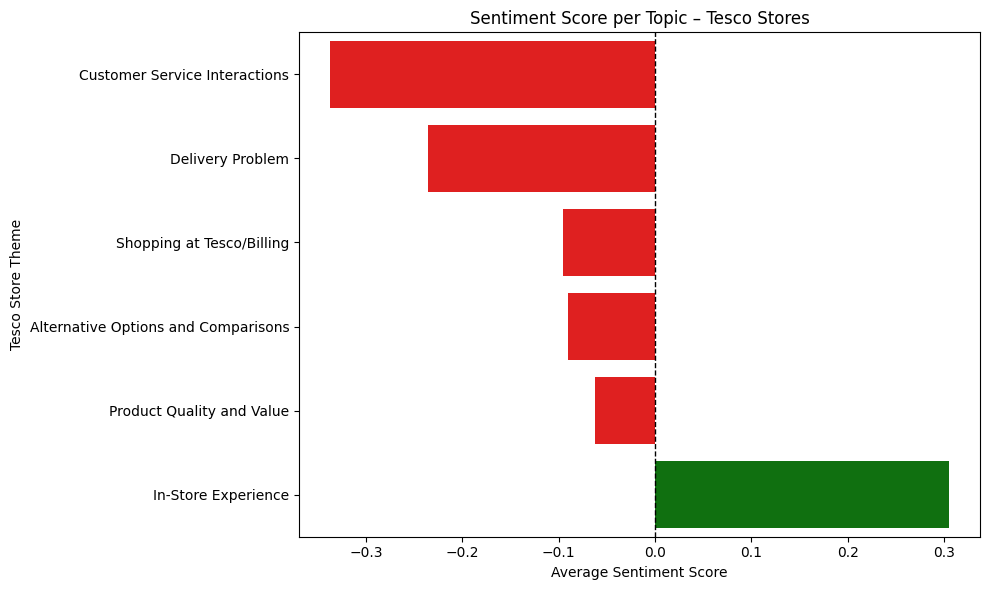

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the sentiment scores
sentiment_by_topic_store = sentiment_by_topic_store.sort_values(ascending=True)

# Generate color list based on sentiment polarity
colors = ['green' if score >= 0 else 'red' for score in sentiment_by_topic_store.values]

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=sentiment_by_topic_store.values,
    y=sentiment_by_topic_store.index,
    palette=colors
)

# Labels and title
plt.xlabel("Average Sentiment Score")
plt.ylabel("Tesco Store Theme")
plt.title("Sentiment Score per Topic – Tesco Stores")
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)  # Neutral reference line

# Clean up
plt.legend([], [], frameon=False)
plt.tight_layout()

# Show plot
plt.show()


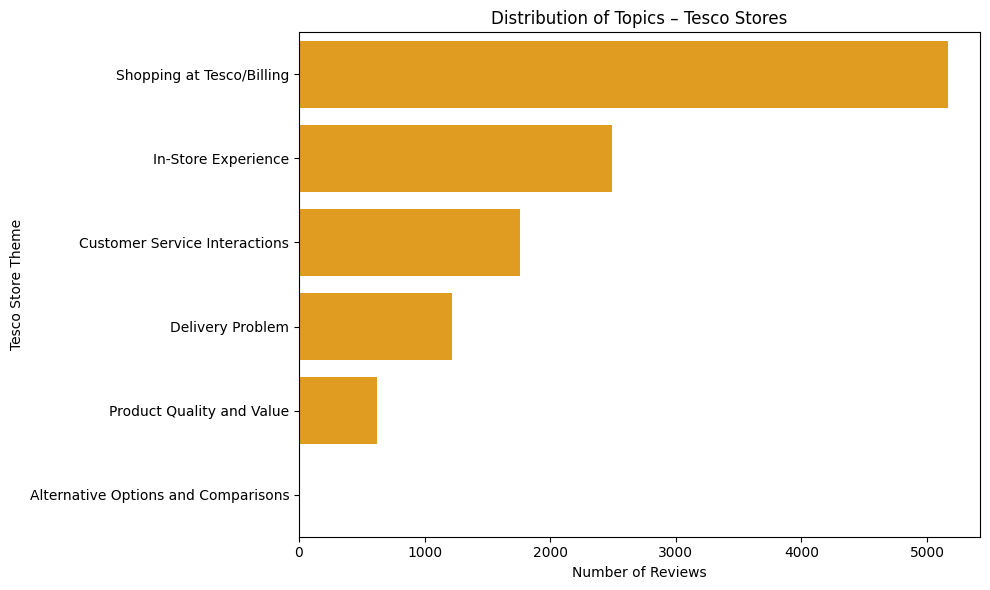

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count number of reviews per dominant topic
topic_distribution_store = df_store["Dominant Topic"].value_counts()

# Create a horizontal bar chart with blue bars
plt.figure(figsize=(10, 6))
sns.barplot(
    x=topic_distribution_store.values,
    y=topic_distribution_store.index,
    color="orange"
)

# Labels and title
plt.xlabel("Number of Reviews")
plt.ylabel("Tesco Store Theme")
plt.title("Distribution of Topics – Tesco Stores")

# Layout and show
plt.tight_layout()
plt.show()


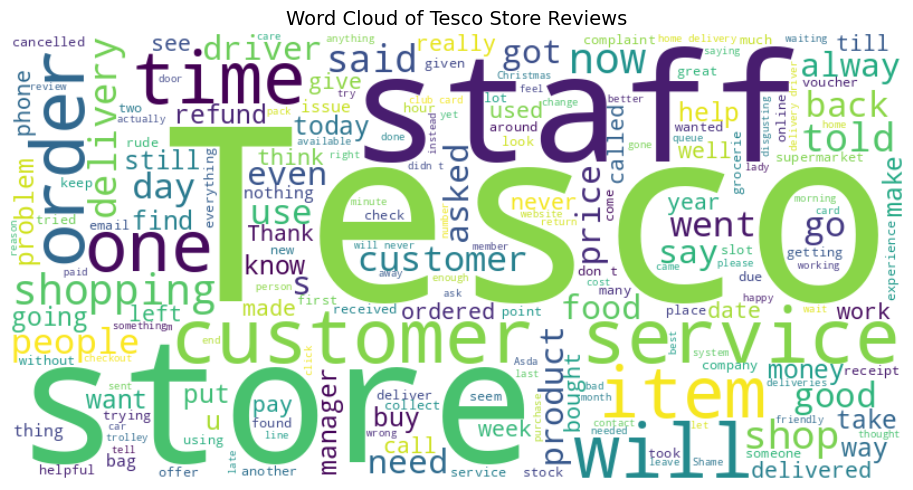

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all Tesco Stores reviews into a single string
all_reviews_store_text = " ".join(df_store["Review Message"].astype(str))

# Generate the word cloud
wordcloud_store = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis"
).generate(all_reviews_store_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_store, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Tesco Store Reviews", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
def classify_sentiment(score):
    if score >= 0.3:
        return "Positive"
    elif score <= -0.1:
        return "Negative"
    else:
        return "Neutral"

df_store["Sentiment Category"] = df_store["Sentiment Score"].apply(classify_sentiment)


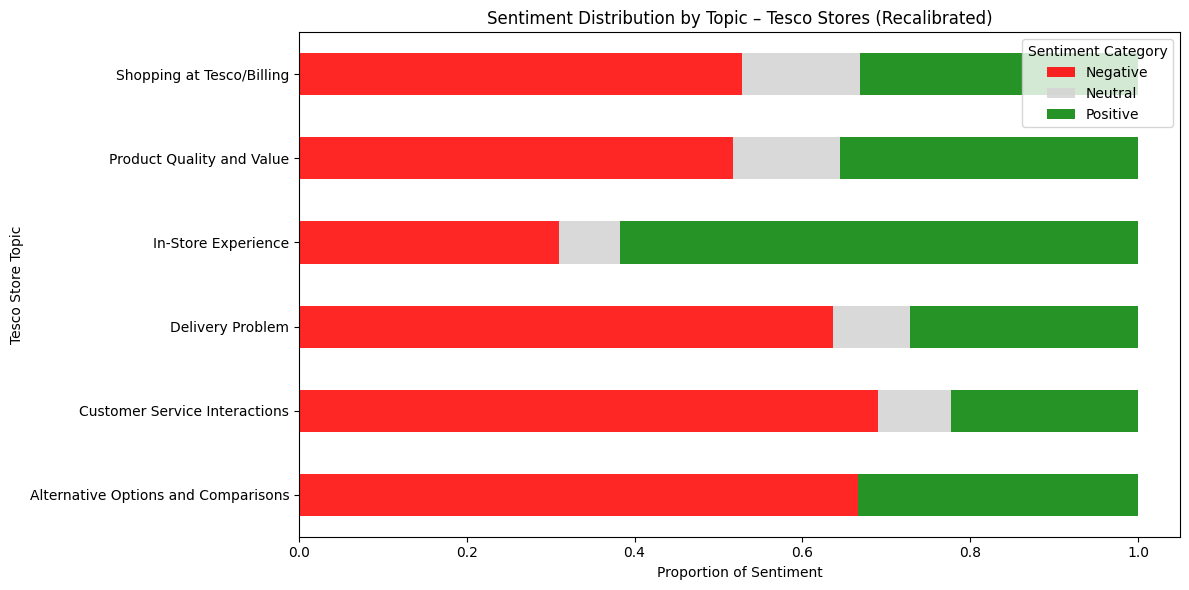

In [ ]:
# Recalculate sentiment distribution per topic
sentiment_distribution_store = (
    df_store.groupby("Dominant Topic")["Sentiment Category"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# Ensure column order
sentiment_distribution_store = sentiment_distribution_store[["Negative", "Neutral", "Positive"]]

# Plot
sentiment_distribution_store.plot(
    kind="barh",
    stacked=True,
    color=["red", "lightgrey", "green"],  # manual mapping
    alpha=0.85,
    figsize=(12, 6)
)

plt.xlabel("Proportion of Sentiment")
plt.ylabel("Tesco Store Topic")
plt.title("Sentiment Distribution by Topic – Tesco Stores (Recalibrated)")
plt.legend(title="Sentiment Category")
plt.tight_layout()
plt.show()


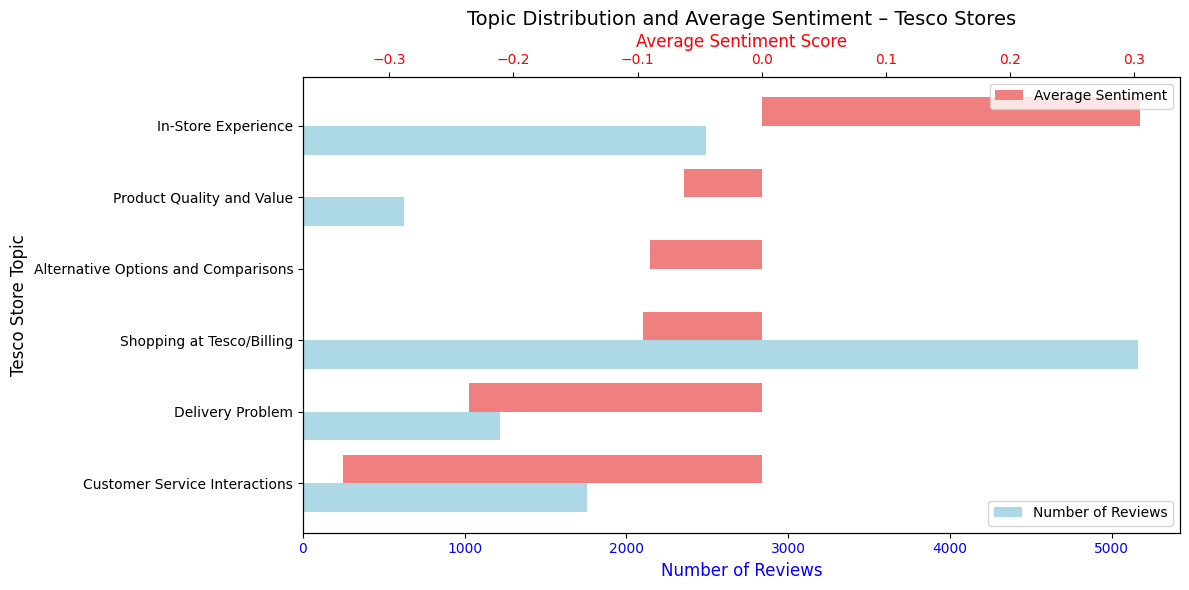

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare matching topic order
topics_store = list(sentiment_by_topic_store.index)  # topics in sentiment order

# Ensure the same topic order for review counts
review_counts_store = np.array([df_store["Dominant Topic"].value_counts().get(topic, 0) for topic in topics_store])
sentiment_scores_store = np.array([sentiment_by_topic_store[topic] for topic in topics_store])

# Step 2: Create plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar positions
y_pos = np.arange(len(topics_store))

# Plot review counts (Blue bars)
ax1.barh(y_pos - 0.2, review_counts_store, color="lightblue", height=0.4, label="Number of Reviews")
ax1.set_xlabel("Number of Reviews", color="blue", fontsize=12)
ax1.set_ylabel("Tesco Store Topic", fontsize=12)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(topics_store)
ax1.tick_params(axis="x", labelcolor="blue")

# Plot sentiment scores (Red bars on second x-axis)
ax2 = ax1.twiny()
ax2.barh(y_pos + 0.2, sentiment_scores_store, color="lightcoral", height=0.4, label="Average Sentiment")
ax2.set_xlabel("Average Sentiment Score", color="red", fontsize=12)
ax2.tick_params(axis="x", labelcolor="red")

# Title and legends
plt.title("Topic Distribution and Average Sentiment – Tesco Stores", fontsize=14)
ax1.legend(loc="lower right", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Annotated dataset for 3-star reviews tesco bank
dfstore_annotations = pd.read_csv('/content/drive/MyDrive/MSc Dissertation/Tesco Stores Review (1).csv')  # should have columns like: review_text, annotated_sentiment


# Inspect the data
print(dfstore_annotations.head())


                                              Review Annotation
0  This relates to my local 'Superstore', althoug...   Negative
1  It’s quite good value. The selection is OK but...   Negative
2  Tesco generally good on the grocery side of th...   Negative
3  Called in tesco pontardawe just for a few item...  Negative 
4  I've been with Asda for some time and decide t...  Negative 


In [ ]:
df_store = df_store.merge(
    dfstore_annotations[['Review', 'Annotation']],
    left_on='Review Message',
    right_on='Review',
    how='left'
)


In [ ]:
df_store.drop(columns='Review', inplace=True)

In [ ]:
df_store.head()

,Author Name,Review Message,Review Date,Star Rating,Sentiment Label,cleaned_text,Sentiment Score,Topic,Dominant Topic,Sentiment Category,Annotation
0,Monika Matuszewska,Tesco Newbury home delivery.This is disgusting...,2025-01-20,1,Negative,"[tesco, newbury, home, disgusting, receive_mes...",0.3818,"[(3, 0.52180296)]",Customer Service Interactions,Positive,NaN
1,Louise,I have been shopping in Tesco for years. I hav...,2025-01-20,1,Negative,"[shop, tesco, year, shopping, deliver, big, fa...",-0.6808,"[(2, 0.33029276)]",Shopping at Tesco/Billing,Negative,NaN
2,Roger Nicholls,Purchased a Tesco Hearty Food Co Spaghetti Bol...,2025-01-21,1,Negative,"[purchase, tesco, hearty, food, spaghetti, bol...",-0.2111,"[(3, 0.37819335)]",Customer Service Interactions,Negative,NaN
3,Mark Eley,Last shop ever at Tesco just do not trust the ...,2025-01-22,1,Negative,"[shop, tesco, trust, quality_food, chicken_bre...",-0.3616,"[(2, 0.48685977)]",Shopping at Tesco/Billing,Negative,NaN
4,Carole Sefton,The app on my phone has stopped working althou...,2025-01-20,1,Negative,"[app, phone, stop, work, change, try, uninstal...",-0.7300,"[(2, 0.37671325)]",Shopping at Tesco/Billing,Negative,NaN


In [ ]:
def define_expected_sentiment(row):
    if pd.notnull(row['Annotation']):
        return row['Annotation'].capitalize()
    elif row['Star Rating'] in [1, 2]:
        return 'Negative'
    elif row['Star Rating'] in [4, 5]:
        return 'Positive'
    else:
        return 'Neutral'  # For 3-star reviews without annotations


In [ ]:
df_store['Expected Sentiment'] = df_store.apply(define_expected_sentiment, axis=1)

In [ ]:
df_store.head()

,Author Name,Review Message,Review Date,Star Rating,Sentiment Label,cleaned_text,Sentiment Score,Topic,Dominant Topic,Sentiment Category,Annotation,Expected Sentiment
0,Monika Matuszewska,Tesco Newbury home delivery.This is disgusting...,2025-01-20,1,Negative,"[tesco, newbury, home, disgusting, receive_mes...",0.3818,"[(3, 0.52180296)]",Customer Service Interactions,Positive,NaN,Negative
1,Louise,I have been shopping in Tesco for years. I hav...,2025-01-20,1,Negative,"[shop, tesco, year, shopping, deliver, big, fa...",-0.6808,"[(2, 0.33029276)]",Shopping at Tesco/Billing,Negative,NaN,Negative
2,Roger Nicholls,Purchased a Tesco Hearty Food Co Spaghetti Bol...,2025-01-21,1,Negative,"[purchase, tesco, hearty, food, spaghetti, bol...",-0.2111,"[(3, 0.37819335)]",Customer Service Interactions,Negative,NaN,Negative
3,Mark Eley,Last shop ever at Tesco just do not trust the ...,2025-01-22,1,Negative,"[shop, tesco, trust, quality_food, chicken_bre...",-0.3616,"[(2, 0.48685977)]",Shopping at Tesco/Billing,Negative,NaN,Negative
4,Carole Sefton,The app on my phone has stopped working althou...,2025-01-20,1,Negative,"[app, phone, stop, work, change, try, uninstal...",-0.7300,"[(2, 0.37671325)]",Shopping at Tesco/Billing,Negative,NaN,Negative


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Step 1: Set up ground truth and predicted labels
y_true = df_store['Expected Sentiment']
y_pred = df_store['Sentiment Category']  # VADER's predicted category

# Step 2: Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Step 3: Display metrics
print(f"✅ Accuracy: {accuracy:.2f}")
print(f"✅ Precision: {precision:.2f}")
print(f"✅ Recall: {recall:.2f}")
print(f"✅ F1 Score: {f1:.2f}")

# Step 4: Detailed classification report
print("\n📊 Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    labels=["Negative", "Neutral", "Positive"],
    target_names=["Negative", "Neutral", "Positive"],
    zero_division=0
))


✅ Accuracy: 0.68
✅ Precision: 0.81
✅ Recall: 0.68
✅ F1 Score: 0.71

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.66      0.77     10956
     Neutral       0.04      0.25      0.08       317
    Positive       0.53      0.85      0.65      3601

   micro avg       0.68      0.69      0.69     14874
   macro avg       0.51      0.59      0.50     14874
weighted avg       0.82      0.69      0.73     14874



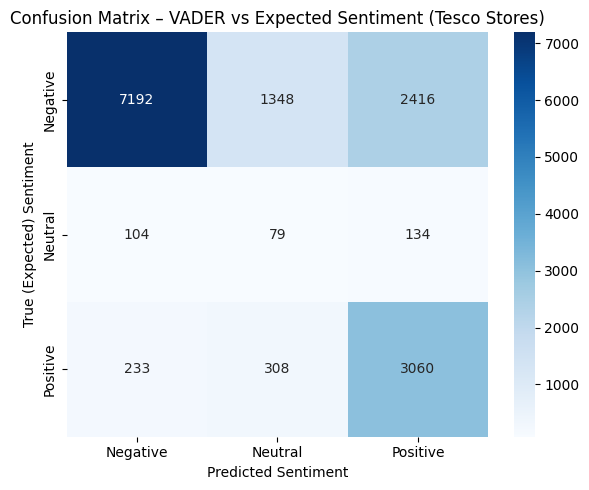

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["Negative", "Neutral", "Positive"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Sentiment")
plt.ylabel("True (Expected) Sentiment")
plt.title("Confusion Matrix – VADER vs Expected Sentiment (Tesco Stores)")
plt.tight_layout()
plt.show()


In [ ]:
!pip install transformers torch emoji

In [ ]:
import re

# Define lightweight cleaning function
def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip()             # Remove extra whitespace
    text = text.replace('\n', ' ').replace('\r', ' ')    # Flatten line breaks
    return text

# Apply to Tesco Store dataset
df_store['Review Message'] = df_store['Review Message'].apply(clean_text)


In [ ]:
def batch_bert_sentiment(texts, batch_size=32):
    sentiments = []
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

        batch_sentiments = [labels[p] for p in preds]
        sentiments.extend(batch_sentiments)

    return sentiments


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Force use of CPU
device = torch.device('cpu')
model.to(device)

# Define label map
labels = ['Negative', 'Neutral', 'Positive']


In [ ]:
df_store['RoBERTa Sentiment'] = batch_bert_sentiment(df_store['Review Message'].tolist())

KeyboardInterrupt: 

In [ ]:
import torch
torch.cuda.is_available()


True

In [ ]:
def batch_bert_sentiment(texts, batch_size=8):  # reduce batch size
    sentiments = []
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        print(f"Processing batch {i}-{i+batch_size}...")  # track progress

        try:
            inputs = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)
                preds = torch.argmax(probs, dim=1)

            batch_sentiments = [labels[p] for p in preds]
            sentiments.extend(batch_sentiments)

        except Exception as e:
            print(f"⚠️ Error in batch {i}-{i+batch_size}: {e}")
            sentiments.extend([None]*len(batch_texts))

    return sentiments


In [ ]:
df_test = df_store.head(50).copy()
df_test['RoBERTa Sentiment'] = batch_bert_sentiment(df_test['Review Message'].tolist())


Processing batch 0-8...
Processing batch 8-16...
Processing batch 16-24...
Processing batch 24-32...
Processing batch 32-40...
Processing batch 40-48...
Processing batch 48-56...


In [ ]:
# Store predictions here
roberta_sentiments = []

# Define batch size (adjust if needed)
batch_size = 64

# Total number of reviews
texts = df_store['Review Message'].dropna().tolist()
total = len(texts)

# Process in batches
for i in range(0, total, batch_size):
    print(f"Processing batch {i} to {min(i + batch_size, total)}...")
    batch_texts = texts[i:i+batch_size]
    batch_preds = batch_bert_sentiment(batch_texts)
    roberta_sentiments.extend(batch_preds)


Processing batch 0 to 64...
Processing batch 0-8...
Processing batch 8-16...
Processing batch 16-24...
Processing batch 24-32...
Processing batch 32-40...
Processing batch 40-48...
Processing batch 48-56...
Processing batch 56-64...
Processing batch 64 to 128...
Processing batch 0-8...
Processing batch 8-16...
Processing batch 16-24...
Processing batch 24-32...
Processing batch 32-40...
Processing batch 40-48...
Processing batch 48-56...
Processing batch 56-64...
Processing batch 128 to 192...
Processing batch 0-8...
Processing batch 8-16...
Processing batch 16-24...
Processing batch 24-32...
Processing batch 32-40...
Processing batch 40-48...
Processing batch 48-56...
Processing batch 56-64...
Processing batch 192 to 256...
Processing batch 0-8...
Processing batch 8-16...
Processing batch 16-24...
Processing batch 24-32...
Processing batch 32-40...
Processing batch 40-48...
Processing batch 48-56...
Processing batch 56-64...
Processing batch 256 to 320...
Processing batch 0-8...
Proce

In [ ]:
# Add the results as a new column
df_store = df_store.copy()
df_store.loc[:len(roberta_sentiments)-1, 'RoBERTa Sentiment'] = roberta_sentiments


In [ ]:
df_store[['Review Message', 'Expected Sentiment', 'RoBERTa Sentiment']].head()


,Review Message,Expected Sentiment,RoBERTa Sentiment
0,tesco newbury home delivery.this is disgusting...,Negative,Negative
1,i have been shopping in tesco for years. i hav...,Negative,Negative
2,purchased a tesco hearty food co spaghetti bol...,Negative,Negative
3,last shop ever at tesco just do not trust the ...,Negative,Negative
4,the app on my phone has stopped working althou...,Negative,Negative


In [ ]:
def batch_bert_sentiment_scores(texts, batch_size=32):
    all_scores = []
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        print(f"Processing batch {i}-{i+batch_size}...")

        try:
            inputs = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)

            # Assign sentiment score: Negative = -1, Neutral = 0, Positive = +1
            weights = torch.tensor([-1, 0, 1], device=device).float()
            scores = (probs * weights).sum(dim=1).tolist()  # weighted average

            all_scores.extend(scores)

        except Exception as e:
            print(f"⚠️ Error in batch {i}-{i+batch_size}: {e}")
            all_scores.extend([None] * len(batch_texts))

    return all_scores


In [ ]:
# Run it on all reviews
sentiment_score_list = batch_bert_sentiment_scores(df_store['Review Message'].tolist())

# Add to df_store
df_store['RoBERTa Sentiment Score'] = sentiment_score_list


Processing batch 0-32...
Processing batch 32-64...
Processing batch 64-96...
Processing batch 96-128...
Processing batch 128-160...
Processing batch 160-192...
Processing batch 192-224...
Processing batch 224-256...
Processing batch 256-288...
Processing batch 288-320...
Processing batch 320-352...
Processing batch 352-384...
Processing batch 384-416...
Processing batch 416-448...
Processing batch 448-480...
Processing batch 480-512...
Processing batch 512-544...
Processing batch 544-576...
Processing batch 576-608...
Processing batch 608-640...
Processing batch 640-672...
Processing batch 672-704...
Processing batch 704-736...
Processing batch 736-768...
Processing batch 768-800...
Processing batch 800-832...
Processing batch 832-864...
Processing batch 864-896...
Processing batch 896-928...
Processing batch 928-960...
Processing batch 960-992...
Processing batch 992-1024...
Processing batch 1024-1056...
Processing batch 1056-1088...
Processing batch 1088-1120...
Processing batch 1120

In [ ]:
df_store.head()

,Author Name,Review Message,Review Date,Star Rating,Sentiment Label,cleaned_text,Sentiment Score,Topic,Dominant Topic,Sentiment Category,Annotation,Expected Sentiment,RoBERTa Sentiment,RoBERTa Sentiment Score
0,Monika Matuszewska,tesco newbury home delivery.this is disgusting...,2025-01-20,1,Negative,"[tesco, newbury, home, disgusting, receive_mes...",0.3818,"[(3, 0.52180296)]",Customer Service Interactions,Positive,NaN,Negative,Negative,-0.876532
1,Louise,i have been shopping in tesco for years. i hav...,2025-01-20,1,Negative,"[shop, tesco, year, shopping, deliver, big, fa...",-0.6808,"[(2, 0.33029276)]",Shopping at Tesco/Billing,Negative,NaN,Negative,Negative,-0.772199
2,Roger Nicholls,purchased a tesco hearty food co spaghetti bol...,2025-01-21,1,Negative,"[purchase, tesco, hearty, food, spaghetti, bol...",-0.2111,"[(3, 0.37819335)]",Customer Service Interactions,Negative,NaN,Negative,Negative,-0.851416
3,Mark Eley,last shop ever at tesco just do not trust the ...,2025-01-22,1,Negative,"[shop, tesco, trust, quality_food, chicken_bre...",-0.3616,"[(2, 0.48685977)]",Shopping at Tesco/Billing,Negative,NaN,Negative,Negative,-0.967023
4,Carole Sefton,the app on my phone has stopped working althou...,2025-01-20,1,Negative,"[app, phone, stop, work, change, try, uninstal...",-0.7300,"[(2, 0.37671325)]",Shopping at Tesco/Billing,Negative,NaN,Negative,Negative,-0.929120


In [ ]:
# Group by Dominant Topic and calculate average RoBERTa sentiment score
avg_sentiment_per_topic = df_store.groupby("Dominant Topic")["RoBERTa Sentiment Score"].mean().sort_values()

# Display as a neat table
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)  # format float nicely
avg_sentiment_per_topic = avg_sentiment_per_topic.reset_index()
avg_sentiment_per_topic.columns = ['Topic', 'Average RoBERTa Sentiment Score']
avg_sentiment_per_topic


,Topic,Average RoBERTa Sentiment Score
0,Customer Service Interactions,-0.721
1,Delivery Problem,-0.554
2,Shopping at Tesco/Billing,-0.545
3,Product Quality and Value,-0.530
4,Alternative Options and Comparisons,-0.114
5,In-Store Experience,0.129


In [ ]:
# Evaluate RoBERTa predictions
y_true = df_store['Expected Sentiment']
y_pred = df_store['RoBERTa Sentiment']

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"✅ RoBERTa Accuracy: {accuracy:.2f}")
print(f"✅ RoBERTa Precision: {precision:.2f}")
print(f"✅ RoBERTa Recall: {recall:.2f}")
print(f"✅ RoBERTa F1 Score: {f1:.2f}")

print("\n📊 RoBERTa Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    labels=["Negative", "Neutral", "Positive"],
    target_names=["Negative", "Neutral", "Positive"],
    zero_division=0
))


✅ RoBERTa Accuracy: 0.88
✅ RoBERTa Precision: 0.90
✅ RoBERTa Recall: 0.88
✅ RoBERTa F1 Score: 0.89

📊 RoBERTa Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.93      0.93     10956
     Neutral       0.07      0.20      0.10       317
    Positive       0.91      0.88      0.90      3601

   micro avg       0.88      0.90      0.89     14874
   macro avg       0.64      0.67      0.64     14874
weighted avg       0.92      0.90      0.91     14874



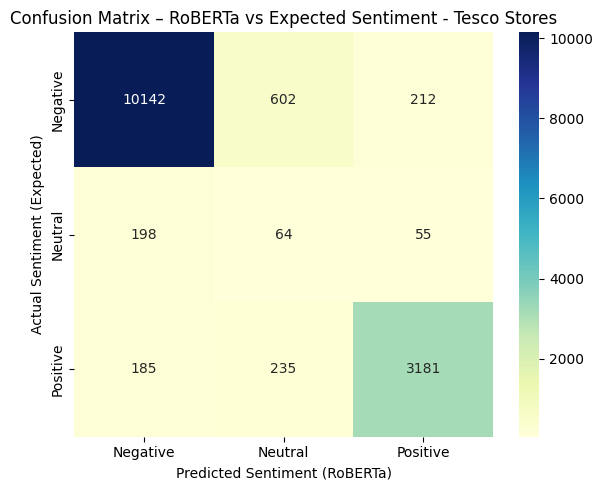

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define labels for consistency
labels = ['Negative', 'Neutral', 'Positive']

# Create confusion matrix
cm = confusion_matrix(df_store['Expected Sentiment'], df_store['RoBERTa Sentiment'], labels=labels)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Sentiment (RoBERTa)")
plt.ylabel("Actual Sentiment (Expected)")
plt.title("Confusion Matrix – RoBERTa vs Expected Sentiment - Tesco Stores")
plt.tight_layout()
plt.show()


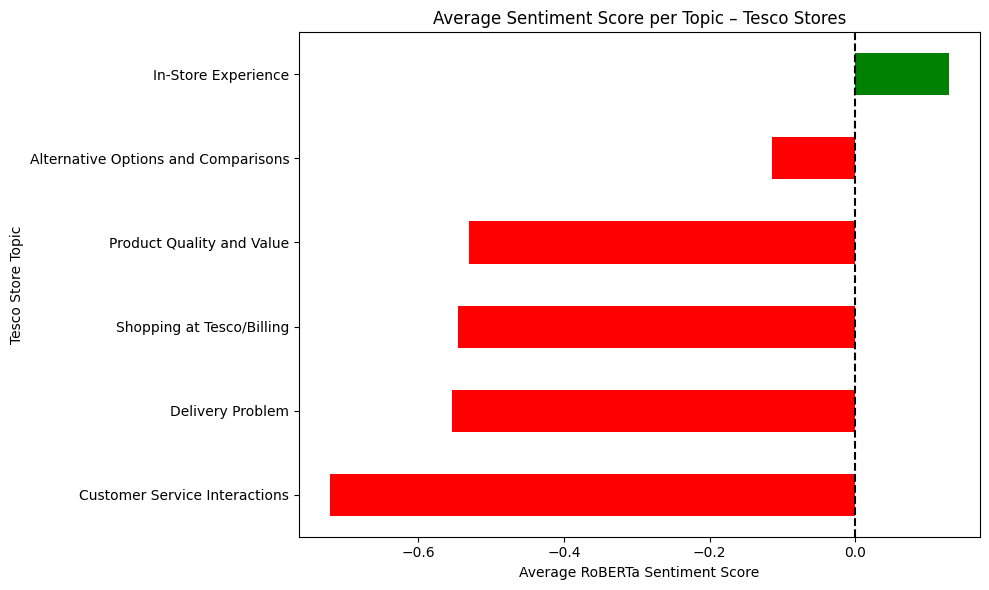

In [ ]:
import matplotlib.pyplot as plt

# Recalculate average sentiment per topic
avg_sentiment = df_store.groupby("Dominant Topic")["RoBERTa Sentiment Score"].mean().sort_values()

# Define colors based on score
colors = ['green' if val > 0 else 'red' for val in avg_sentiment]

# Plot with conditional colors
plt.figure(figsize=(10, 6))
avg_sentiment.plot(kind="barh", color=colors)
plt.xlabel("Average RoBERTa Sentiment Score")
plt.ylabel("Tesco Store Topic")
plt.title("Average Sentiment Score per Topic – Tesco Stores")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


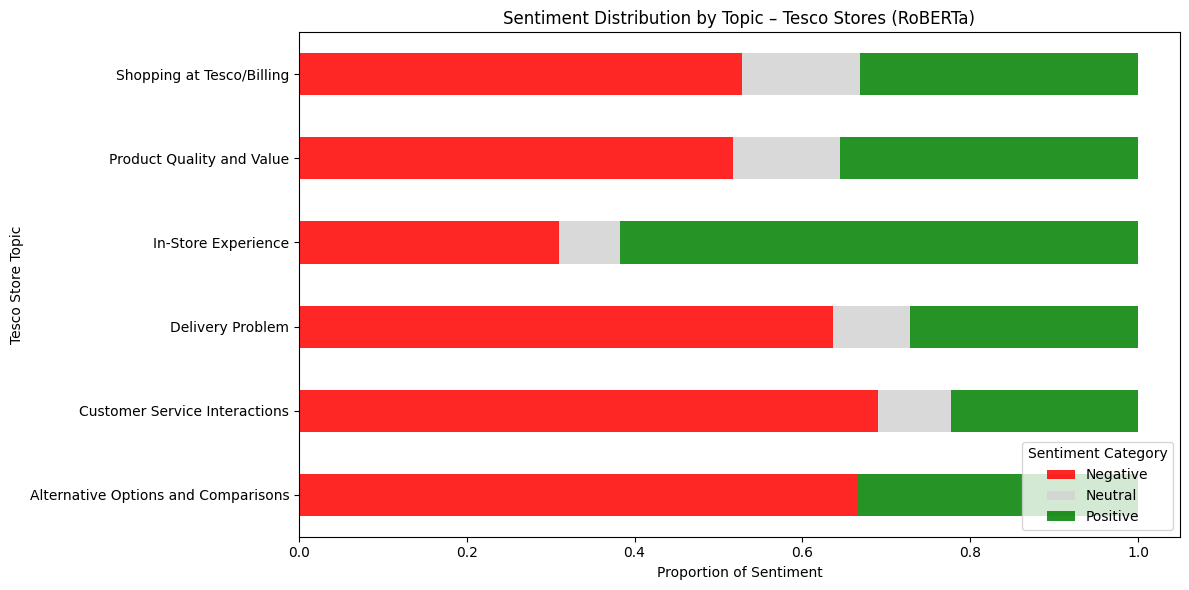

In [ ]:
# Step 2: Ensure column order
sentiment_distribution_store = sentiment_distribution_store[["Negative", "Neutral", "Positive"]]

# Step 3: Plot stacked horizontal bar chart
sentiment_distribution_store.plot(
    kind="barh",
    stacked=True,
    color=["red", "lightgrey", "green"],  # Custom sentiment colors
    alpha=0.85,
    figsize=(12, 6)
)

plt.xlabel("Proportion of Sentiment")
plt.ylabel("Tesco Store Topic")
plt.title("Sentiment Distribution by Topic – Tesco Stores (RoBERTa)")
plt.legend(title="Sentiment Category", loc="lower right")
plt.tight_layout()
plt.show()

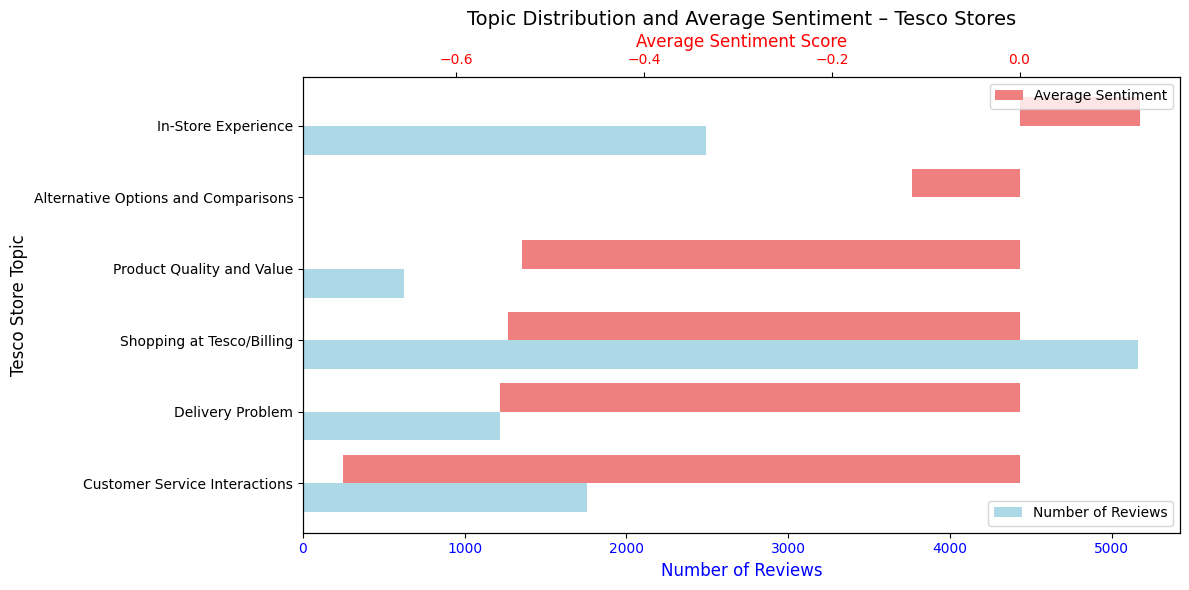

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Make sure average sentiment per topic is calculated
sentiment_by_topic_store = df_store.groupby("Dominant Topic")["RoBERTa Sentiment Score"].mean().sort_values()

# Step 2: Match topic order across both axes
topics_store = list(sentiment_by_topic_store.index)
review_counts_store = np.array([df_store["Dominant Topic"].value_counts().get(topic, 0) for topic in topics_store])
sentiment_scores_store = np.array([sentiment_by_topic_store[topic] for topic in topics_store])

# Step 3: Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))
y_pos = np.arange(len(topics_store))

# Left axis: Number of reviews (blue bars)
ax1.barh(y_pos - 0.2, review_counts_store, color="lightblue", height=0.4, label="Number of Reviews")
ax1.set_xlabel("Number of Reviews", color="blue", fontsize=12)
ax1.set_ylabel("Tesco Store Topic", fontsize=12)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(topics_store)
ax1.tick_params(axis="x", labelcolor="blue")

# Right axis: Average sentiment score (red bars)
ax2 = ax1.twiny()
ax2.barh(y_pos + 0.2, sentiment_scores_store, color="lightcoral", height=0.4, label="Average Sentiment")
ax2.set_xlabel("Average Sentiment Score", color="red", fontsize=12)
ax2.tick_params(axis="x", labelcolor="red")

# Add title and legends
plt.title("Topic Distribution and Average Sentiment – Tesco Stores", fontsize=14)
ax1.legend(loc="lower right", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Filter negative reviews
df_negative_store = df_store[df_store['Star Rating'].isin([1, 2, 3])].copy()

# If you have trigrammed tokens for the full dataset, do the same for negatives
texts_trigrams_neg = df_negative_store["cleaned_text"]


In [ ]:
texts_lemmatized_neg = lemmatize_texts(texts_trigrams_neg)

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Create Dictionary and Corpus
id2word_neg = Dictionary(texts_lemmatized_neg)
corpus_neg = [id2word_neg.doc2bow(text) for text in texts_lemmatized_neg]

# Train LDA model
lda_model_neg = LdaModel(
    corpus=corpus_neg,
    id2word=id2word_neg,
    num_topics=3,  # You can tune this!
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)


In [ ]:
for idx, topic in lda_model_neg.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.033*"order" + 0.025*"delivery" + 0.020*"time" + 0.019*"day" + 0.017*"tell" + 0.014*"item" + 0.014*"deliver" + 0.013*"service" + 0.012*"customer_service" + 0.012*"phone"
Topic 1: 0.031*"store" + 0.019*"customer" + 0.017*"staff" + 0.016*"shop" + 0.015*"go" + 0.010*"ask" + 0.010*"people" + 0.009*"say" + 0.009*"manager" + 0.008*"want"
Topic 2: 0.029*"buy" + 0.022*"price" + 0.020*"product" + 0.016*"good" + 0.015*"item" + 0.013*"tesco" + 0.009*"food" + 0.009*"bag" + 0.009*"sell" + 0.009*"shop"


In [ ]:
from gensim.models import CoherenceModel

# Build coherence model
coherence_model_neg = CoherenceModel(
    model=lda_model_neg,
    texts=texts_lemmatized_neg,
    dictionary=id2word_neg,
    coherence='c_v'  # You can also try 'u_mass' or 'c_uci' for comparison
)

# Compute the coherence score
coherence_score = coherence_model_neg.get_coherence()
print(f"\n✅ Coherence Score (c_v): {coherence_score:.4f}")



✅ Coherence Score (c_v): 0.5585


In [ ]:
negative_themes = {
0: "Delivery and Order",
1: "In-Store Experience",
2: "Product and Pricing"
}

In [ ]:
# Assign dominant topic using the LDA model for negative reviews
def get_dominant_topic(ldamodel, corpus):
    dominant_topics = []
    for bow in corpus:
        topics = ldamodel.get_document_topics(bow)
        if topics:
            dominant_topic = max(topics, key=lambda x: x[1])[0]
        else:
            dominant_topic = None
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Assign topics to the negative dataset
df_negative_store["LDA Topic"] = get_dominant_topic(lda_model_neg, corpus_neg)


In [ ]:
# Map LDA Topic to human-readable theme
df_negative_store["Complaint Theme"] = df_negative_store["LDA Topic"].map(negative_themes)

# Compute average sentiment score per complaint theme
avg_sentiment_per_theme = (
    df_negative_store.groupby("Complaint Theme")["RoBERTa Sentiment Score"]
    .mean()
    .sort_values()
    .reset_index()
)

# Display table
avg_sentiment_per_theme.columns = ['Complaint Theme', 'Average Sentiment Score']
avg_sentiment_per_theme.style.format({'Average Sentiment Score': '{:.4f}'})


,Complaint Theme,Average Sentiment Score
0,In-Store Experience,-0.7745
1,Delivery and Order,-0.7600
2,Product and Pricing,-0.6771
